In [1]:
import sys
sys.path.append('./src')

from linear import *
import numpy as np
from loss import *
from matplotlib import pyplot as plt
import tools
from non_lineare import *
from sequentiel import * 
from optim import *
from convolution import *
import pandas as pd
from tqdm import tqdm
from sklearn.manifold import TSNE
import seaborn as sns


2023-04-23 14:28:02.439443: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 14:28:02.509540: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 14:28:02.510852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 14:28:03.820564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Lineare

### donnée lineare (regression lineare données y est linearement dependent a x)

In [4]:
def generate_data_lin(alpha,beta):
    x= np.random.uniform(-10,10,alpha).reshape((-1,1))
    e= (np.random.uniform(-100,100,alpha)).reshape((-1,1))  
    y = alpha * x + beta + e 
    return x,y

#deffintion 
x_lin, y_lin = generate_data_lin(30, 10)
loss_mse = MSELoss()


/tmp/ipykernel_4599/1985103692.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


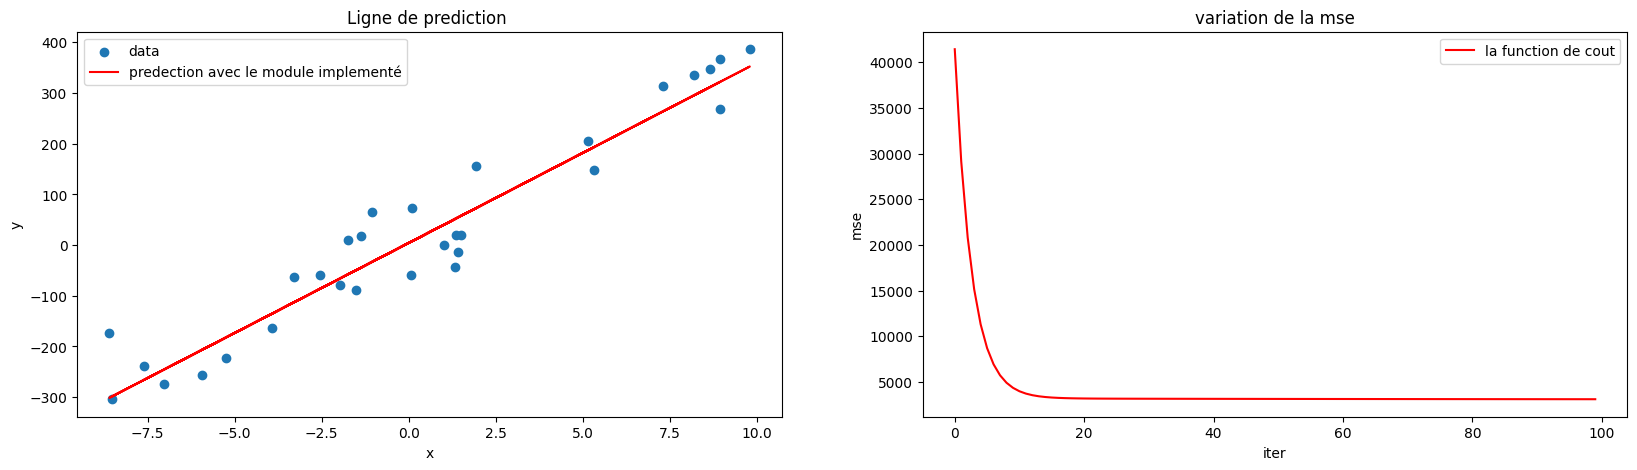

In [3]:
# reseau non profond
# un seul modul d=1,d'=1 un seul neurronne
# lineare

module_lin = Linear(x_lin.shape[1], 1)
iter=100
hist_loss=[]

for _ in range(iter):

    #forward avoir z_h
    y_hat = module_lin.forward(x_lin)
    
    hist_loss.append(loss_mse.forward(y_lin,y_hat).mean())

    #backward calculer dervie de l par rapport z_h
    loss_back = loss_mse.backward(y_lin, y_hat)
        
    module_lin.backward_update_gradient(x_lin, loss_back)
    module_lin.update_parameters(gradient_step=1e-4)
    
    module_lin.zero_grad()


y_hat=module_lin.forward(x_lin)

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(20,5))
ax.flatten()

ax[0].scatter(x_lin,y_lin,label="data")
ax[0].plot(x_lin,y_hat,color='red',label='predection avec le module implementé')
ax[0].legend()
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Ligne de prediction ")

ax[1].plot(np.arange(iter),hist_loss,color='red',label="la function de cout")
ax[1].legend()
ax[1].set_xlabel("iter")
ax[1].set_ylabel("mse")
ax[1].set_title("variation de la mse")

fig.show()

### claasification binaire (données linearement separable)

/tmp/ipykernel_4599/2142189406.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


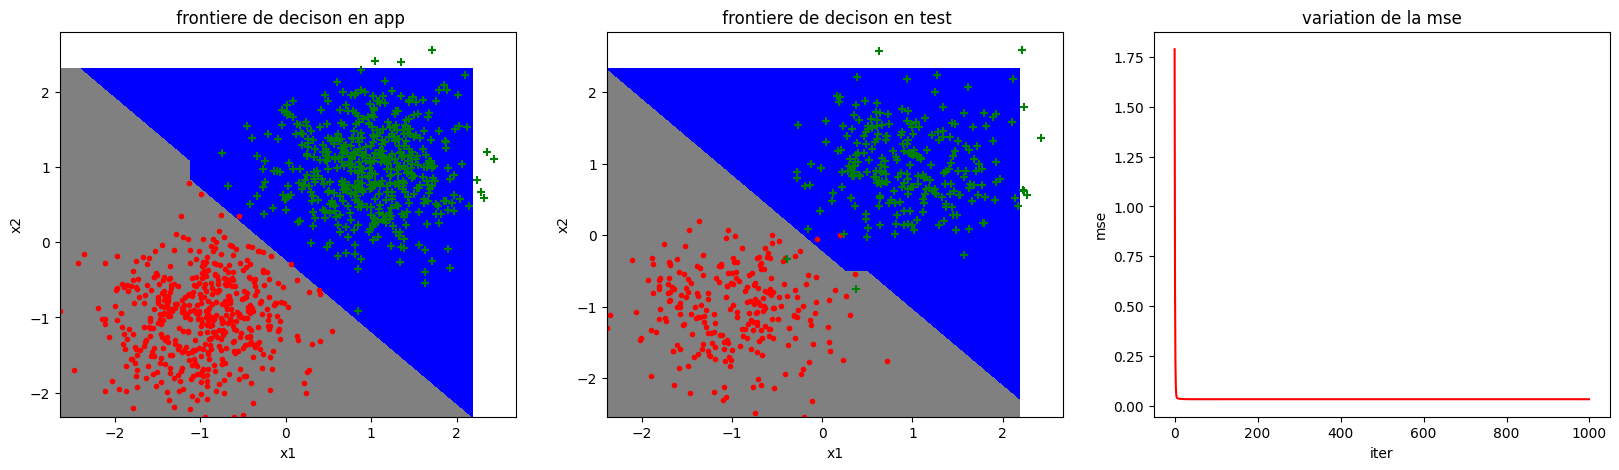

In [4]:
# on a besoin d'un seul nourronne donc d=2, d'=1 (simple aussi) 

batch=1000

x_class, y_class = tools.gen_arti(sigma=0.3, nbex=batch, data_type=0, epsilon=0.1)
x_class_t, y_class_t = tools.gen_arti(sigma=0.3, nbex=500, data_type=0, epsilon=0.1)

y_class = np.where(y_class==-1,0,1).reshape((-1,1))
y_class_t = np.where(y_class_t==-1,0,1).reshape((-1,1))

loss_mse = MSELoss()
module_lin = Linear(x_class.shape[1], 1)

iter=1000
hist_loss=[]

for _ in range(iter):

    #forward avoir z_h
    y_hat = module_lin.forward(x_class)
    
    hist_loss.append(loss_mse.forward(y_class,y_hat).mean())

    #backward calculer dervie de l par rapport z_h
    loss_back = loss_mse.backward(y_class, y_hat)
        
    module_lin.backward_update_gradient(x_class, loss_back)
    module_lin.update_parameters(gradient_step=1e-4)
    
    module_lin.zero_grad()


y_hat=module_lin.forward(x_class)

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(20,5))
ax.flatten()


def sign(x):
    return np.where(module_lin.forward(x)>0.5,1,0)


tools.plot_frontiere(x_class,sign,ax=ax[0])
tools.plot_data(x_class, y_class,ax[0])
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].set_title(" frontiere de decison en app")

tools.plot_frontiere(x_class_t,sign,ax=ax[1])
tools.plot_data(x_class_t, y_class_t,ax[1])
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].set_title(" frontiere de decison en test")


ax[2].plot(np.arange(iter),hist_loss,color='red',label="la function de cout")
ax[2].set_xlabel("iter")
ax[2].set_ylabel("mse")
ax[2].set_title("variation de la mse")
fig.show()


# Non linearement separable

accuracy :  0.997


/tmp/ipykernel_4599/2680353315.py:78: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


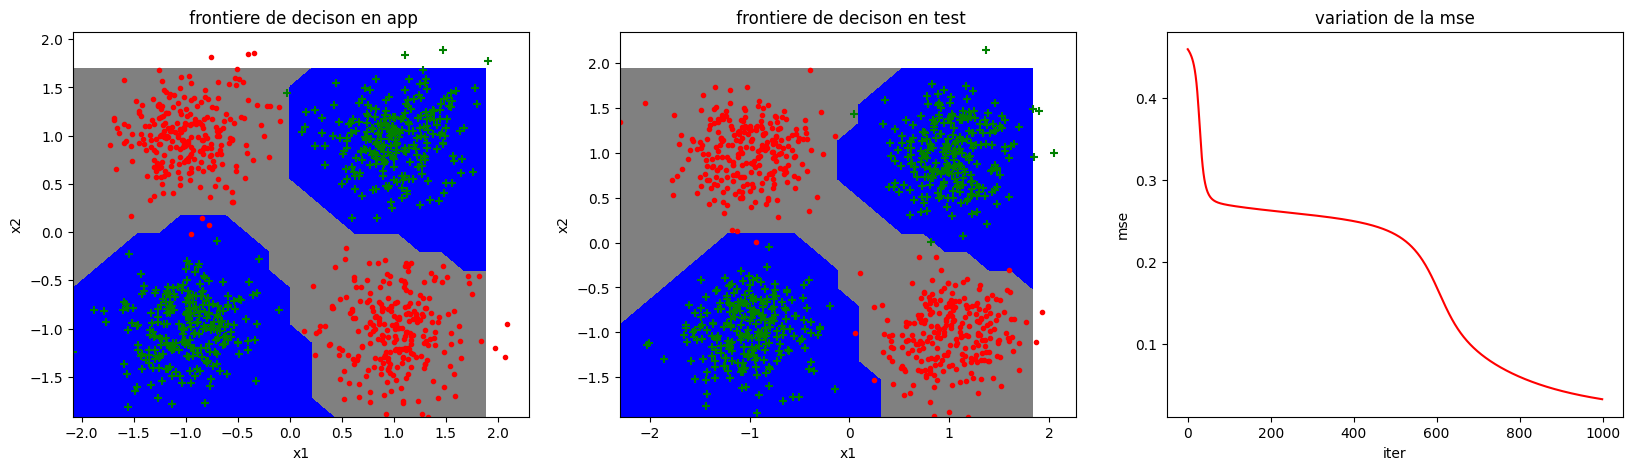

In [5]:

size =1000

datax, datay = tools.gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)
testx, testy = tools.gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)

datay = np.where(datay==-1,0,1).reshape((-1,1))
testy = np.where(testy==-1,0,1).reshape((-1,1))

loss_mse = MSELoss()
modul_lin1 = Linear( datax.shape[1], 4)
modul_lin2 = Linear(4, 1)
modul_sig = Sigmoide()
modul_tan = TanH()


l_loss=[]
iter=1000


for _ in range(iter):
    
    #forward
    new_feautre_lin_1 = modul_lin1.forward(datax)   
    new_feautre_activation_1 = modul_tan.forward(new_feautre_lin_1)
    new_feautre_lin_2 = modul_lin2.forward(new_feautre_activation_1)
    y_hat = modul_sig.forward(new_feautre_lin_2)
    loss = loss_mse.forward(datay,y_hat)
    l_loss.append(loss.mean())
    
    #backward
    loss_back = loss_mse.backward(datay, y_hat)
    delta_sig = modul_sig.backward_delta(new_feautre_lin_2,loss_back)
    delta_lin2 = modul_lin2.backward_delta(new_feautre_activation_1,delta_sig)
    delta_tan = modul_tan.backward_delta(new_feautre_lin_1,delta_lin2)
    delta_lin1 = modul_lin1.backward_delta(datax,delta_tan)


    modul_lin2.backward_update_gradient(new_feautre_activation_1, delta_sig)
    modul_lin1.backward_update_gradient(datax, delta_tan)    

    modul_lin2.update_parameters(gradient_step = 1e-4)
    modul_lin1.update_parameters(gradient_step = 1e-4)
    
    modul_lin1.zero_grad()
    modul_lin2.zero_grad()
    


def predict(x):
    hidden_l = modul_lin1.forward(x)
    hidden_l = modul_tan.forward(hidden_l)
    hidden_l = modul_lin2.forward(hidden_l)
    hidden_l = modul_sig.forward(hidden_l)  
    return np.where(hidden_l >= 0.5,1, 0)

print("accuracy : ",np.where(testy == predict(testx),1,0).mean())

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(20,5))
ax.flatten()

tools.plot_frontiere(datax,predict,ax=ax[0])
tools.plot_data(datax, datay,ax[0])
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].set_title(" frontiere de decison en app")

tools.plot_frontiere(testx,predict,ax=ax[1])
tools.plot_data(testx, testy,ax[1])
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].set_title(" frontiere de decison en test")


ax[2].plot(np.arange(iter),l_loss,color='red',label="la function de cout")
ax[2].set_xlabel("iter")
ax[2].set_ylabel("mse")
ax[2].set_title("variation de la mse")
fig.show()


# Test Encapsulage (Sequential)

100%|██████████| 1000/1000 [00:01<00:00, 823.51it/s]
/tmp/ipykernel_4599/966972139.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


accuracy :  0.979


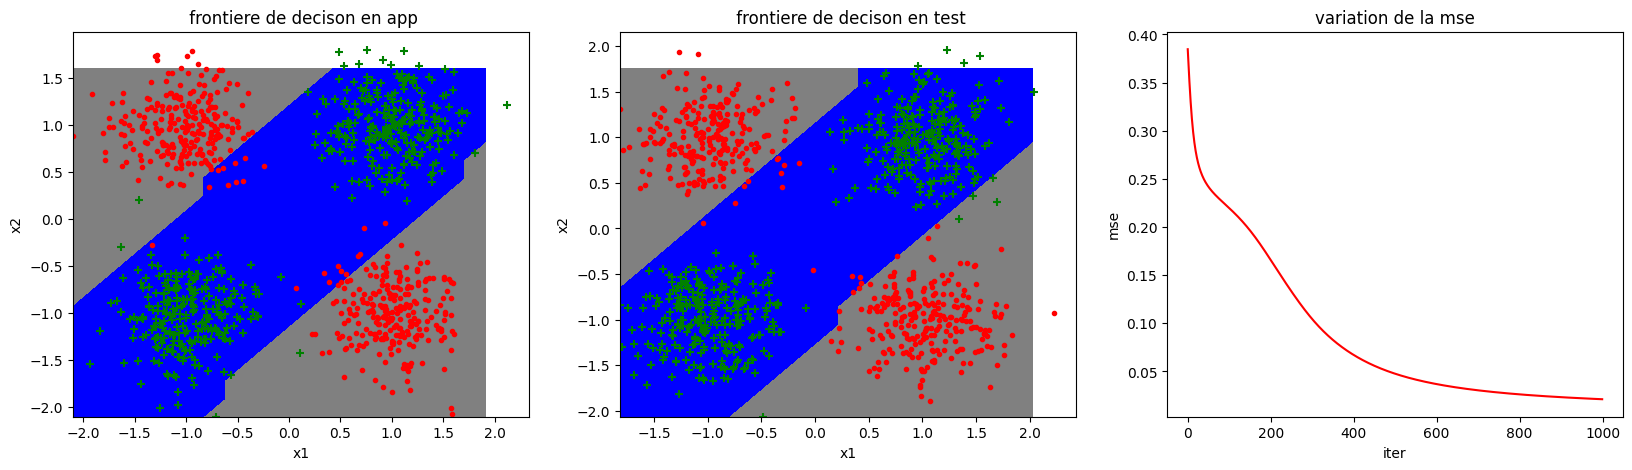

In [6]:

size =1000

datax, datay = tools.gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)
testx, testy = tools.gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=1, epsilon=0.1)

datay = np.where(datay==-1,0,1).reshape((-1,1))
testy = np.where(testy==-1,0,1).reshape((-1,1))

loss_mse = MSELoss()
modul_lin1 = Linear( datax.shape[1], 4)
modul_lin2 = Linear(4, 1)
modul_sig = Sigmoide()
modul_tan = TanH()

l_loss=[]
iter=1000

net= Sequentiel([modul_lin1,modul_tan,modul_lin2,modul_sig],label= lambda x : np.where(x>0.5,1,0))

opt=Optim(net,loss_mse,1e-4)

l_loss=opt.SGD(datax,datay,100,epochs=iter,shuffle=True)

print("accuracy : ", opt.accuracy(datax,datay))

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(20,5))
ax.flatten()

tools.plot_frontiere(datax,opt._net.predict,ax=ax[0])
tools.plot_data(datax, datay,ax[0])
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].set_title(" frontiere de decison en app")

tools.plot_frontiere(testx,opt._net.predict,ax=ax[1])
tools.plot_data(testx, testy,ax[1])
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].set_title(" frontiere de decison en test")


ax[2].plot(np.arange(iter),l_loss,color='red',label="la function de cout")
ax[2].set_xlabel("iter")
ax[2].set_ylabel("mse")
ax[2].set_title("variation de la mse")
fig.show()


100%|██████████| 500/500 [00:04<00:00, 118.02it/s]
/tmp/ipykernel_4599/4026310127.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


accuracy :  0.8906666666666667


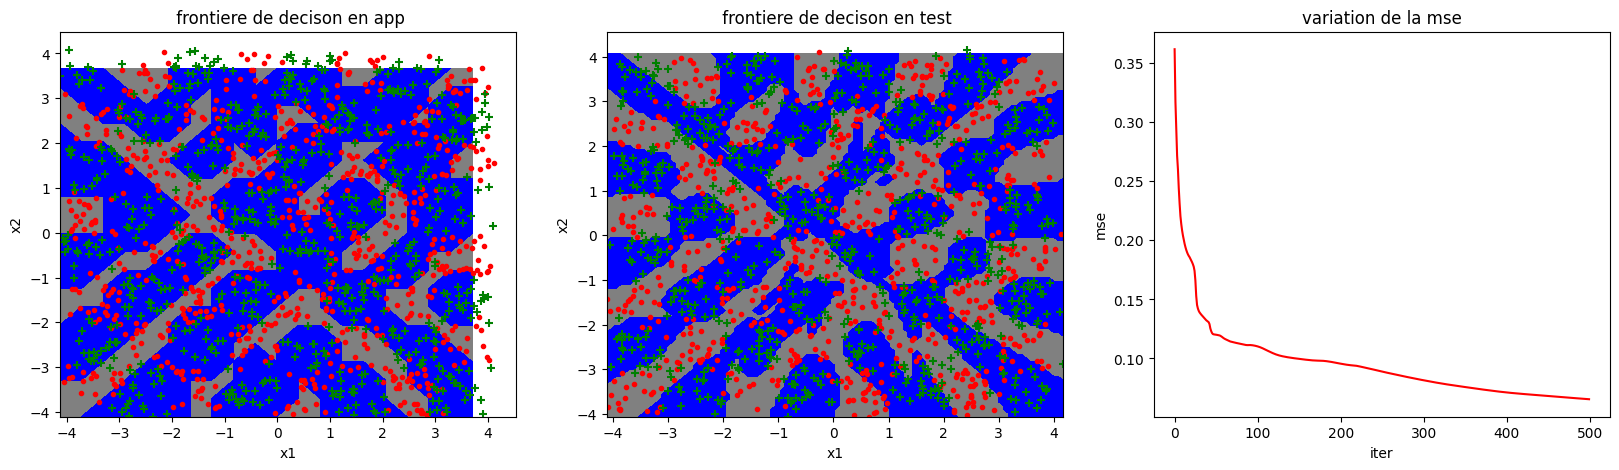

In [7]:
size = 1500
out1=32
out2=64
out3=16
epochs=500

datax, datay = tools.gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=2, epsilon=0.1)
testx, testy = tools.gen_arti(centerx=1, centery=1, sigma=0.1, nbex=size, data_type=2, epsilon=0.1)

datay = np.where(datay==-1,0,1).reshape((-1,1))
testy = np.where(testy==-1,0,1).reshape((-1,1))


loss_mse = MSELoss()
couche_lin = Linear( datax.shape[1], out1)
couche_lin2 = Linear(out1, out2)
couche_lin3 = Linear(out2, out3)
couche_lin4 = Linear(out3, 1)

sig = Sigmoide()
tan = TanH()

net= Sequentiel([couche_lin,tan,couche_lin2,tan,couche_lin3,tan,couche_lin4,sig],label= lambda x : np.where(x>0.5,1,0))

opt=Optim(net,loss_mse,1e-3)

l_loss=opt.SGD(datax,datay,100,epochs=epochs,shuffle=True)

print("accuracy : ",opt.accuracy(datax,datay))

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(20,5))
ax.flatten()

tools.plot_frontiere(datax,opt._net.predict,ax=ax[0])
tools.plot_data(datax, datay,ax[0])
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].set_title(" frontiere de decison en app")

tools.plot_frontiere(testx,opt._net.predict,ax=ax[1],step=100)
tools.plot_data(testx, testy,ax[1])
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].set_title(" frontiere de decison en test")

ax[2].set_xlabel("iter")
ax[2].set_ylabel("mse")
ax[2].set_title("variation de la mse")
ax[2].plot(np.arange(epochs),l_loss,color='red',label="la function de cout")

fig.show()


# multi class

In [8]:
def one_hot(y,size):
    res=np.zeros(size)
    res[y]=1
    return res

### USPS data

In [11]:
path_train = "dataset/USPS_train.txt"
path_test = "dataset/USPS_test.txt"
trainx, trainy_toscore = tools.load_usps(path_train)
testx, testy = tools.load_usps(path_test)

size=len(np.unique(trainy_toscore))
trainy = np.array([ one_hot(y,size) for y in trainy_toscore])

### comparaison entre mse et logsoft_ce

##### couche caché 1->128 2->64

In [14]:
LOGCE_Loss = LOGSOFTCELoss()
MSE_Loss = MSELoss()

net_128_64_ce=Sequentiel([Linear( trainx.shape[1], 128,type=1),TanH(),Linear(128, 64,type=1),TanH(),Linear(64, size,type=1),Softmax()],label= lambda y : np.argmax(y,axis=1))
net_128_64_mse=Sequentiel([Linear( trainx.shape[1], 128,type=1),TanH(),Linear(128, 64,type=1),TanH(),Linear(64, size,type=1),Softmax()],label= lambda y : np.argmax(y,axis=1))

list_loss=[]
list_socre=[]

np.random.seed(5)
for op in ([Optim(net_128_64_ce,LOGCE_Loss,1e-4), Optim(net_128_64_mse,MSE_Loss,1e-4)]) :
   #batch
   list_loss.append( op.SGD(trainx,trainy,trainx.shape[0],epochs=100,shuffle=True) ) 
   list_socre.append ( (op.accuracy(trainx,trainy_toscore ),op.accuracy(testx,testy ) ) )
np.random.seed()

100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


### reseau dense

In [15]:
net_4096_4096_ce=Sequentiel([Linear( trainx.shape[1], 4096,type=1),TanH(),Linear(4096, 4096,type=1),TanH(),Linear(4096, size,type=1),Softmax()],label= lambda y : np.argmax(y,axis=1))
net_4096_4096_mse=Sequentiel([Linear( trainx.shape[1], 4096,type=1),TanH(),Linear(4096, 4096,type=1),TanH(),Linear(4096, size,type=1),Softmax()],label= lambda y : np.argmax(y,axis=1))


np.random.seed(5)
for op in ([Optim(net_4096_4096_ce,LOGCE_Loss,1e-4), Optim(net_4096_4096_mse,MSE_Loss,1e-4)]) :
   #batch
   list_loss.append( op.SGD(trainx,trainy,trainx.shape[0],epochs=100,shuffle=True) ) 
   list_socre.append ( (op.accuracy(trainx,trainy_toscore ),op.accuracy(testx,testy ) ) )
np.random.seed()

100%|██████████| 100/100 [15:27<00:00,  9.27s/it]


### reseau profond

In [22]:
net_profond_ce=Sequentiel([Linear( trainx.shape[1], 256,type=1),TanH(),Linear(256, 128,type=1),TanH(),Linear( 128, 64,type=1),TanH(),Linear(64, 32,type=1),
                           Linear( 32, 16,type=1),TanH(),Linear(16, 8,type=1),Linear( 8, 4,type=1),TanH(),Linear( 4, 8,type=1),TanH(),Linear( 8, 16,type=1),TanH(),
                           Linear( 16, 32,type=1),TanH(),Linear(32, size,type=1),Softmax()],label= lambda y : np.argmax(y,axis=1))

net_profond_mse=Sequentiel([Linear( trainx.shape[1], 256,type=1),TanH(),Linear(256, 128,type=1),TanH(),Linear( 128, 64,type=1),TanH(),Linear(64, 32,type=1),
                           Linear( 32, 16,type=1),TanH(),Linear(16, 8,type=1),Linear( 8, 4,type=1),TanH(),Linear( 4, 8,type=1),TanH(),Linear( 8, 16,type=1),TanH(),
                           Linear( 16, 32,type=1),TanH(),Linear(32, size,type=1),Softmax()],label= lambda y : np.argmax(y,axis=1))

np.random.seed(5)
for op in ([Optim(net_profond_ce,LOGCE_Loss,1e-4), Optim(net_profond_mse,MSE_Loss,1e-4)]) :
   #batch
   list_loss.append( op.SGD(trainx,trainy,trainx.shape[0],epochs=100,shuffle=True) ) 
   list_socre.append ( (op.accuracy(trainx,trainy_toscore ),op.accuracy(testx,testy ) ) )
np.random.seed()

100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


In [23]:
d = {'mse train'  : [list_socre[1][0], list_socre[3][0], list_socre[5][0]], 'mse test' : [list_socre[1][1], list_socre[3][1], list_socre[5][1]],
     'softmax train' : [list_socre[0][0], list_socre[2][0], list_socre[4][0]],'softmax test' : [list_socre[0][1], list_socre[2][1], list_socre[4][1]]
     }
    
d = pd.DataFrame(data=d, index=['128/64', 'dense', 'profond'])
d

,mse train,mse test,softmax train,softmax test
128/64,0.962557,0.913303,0.773694,0.742900
dense,0.137841,0.131540,0.605953,0.584454
profond,0.484433,0.471350,0.229461,0.205780


    on remarque que la sofmax est meilleur que la mse et meme les reseau dense et profond sont moins performant a cause de l'evaporation du gradient

#### visualisation des fonction de cout

/tmp/ipykernel_4599/1697468238.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


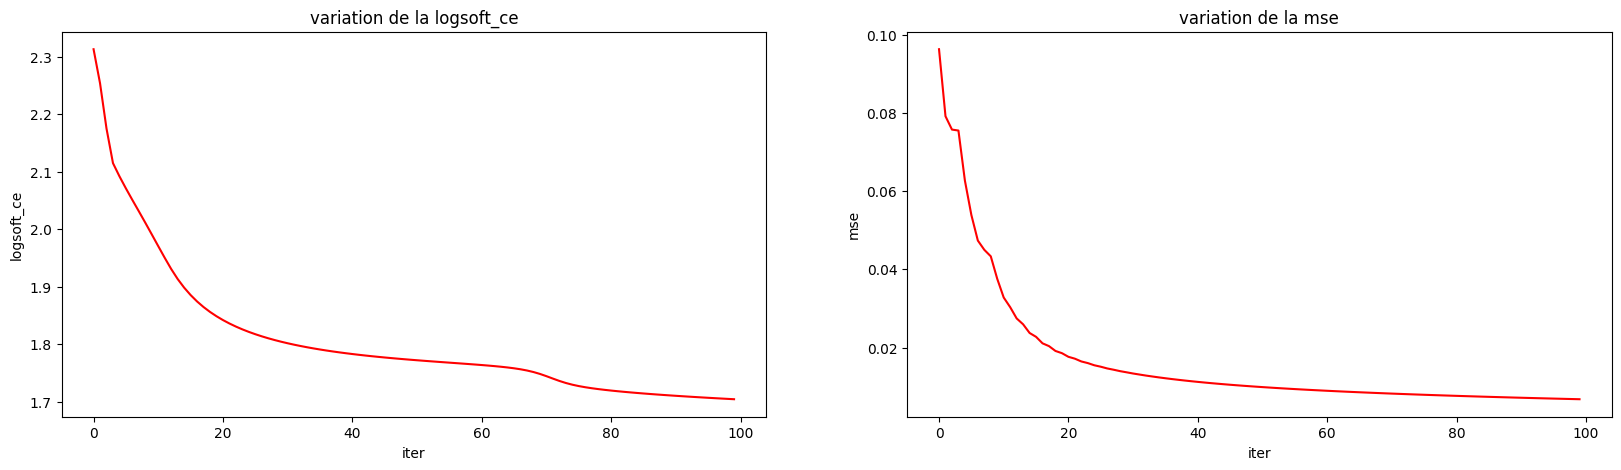

In [24]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(20,5))
ax.flatten()

ax[0].set_xlabel("iter")
ax[0].set_ylabel("logsoft_ce")
ax[0].set_title("variation de la logsoft_ce")
ax[0].plot(np.arange(100),list_loss[0],color='red',label="la function de cout")

ax[1].set_xlabel("iter")
ax[1].set_ylabel("mse")
ax[1].set_title("variation de la mse")
ax[1].plot(np.arange(100),list_loss[1],color='red',label="la function de cout")

fig.show()

#### faire un mini batch

In [25]:
net_128_64=Sequentiel([Linear( trainx.shape[1], 128,type=1),TanH(),Linear(128, 64,type=1),TanH(),Linear(64, size,type=1),Softmax()],label= lambda y : np.argmax(y,axis=1))
op=Optim(net_128_64,LOGCE_Loss,1e-4)
op.SGD(trainx,trainy,100,epochs=1000,shuffle=True)

print(f"accracy : train {op.accuracy(trainx,trainy_toscore )} test {op.accuracy(testx,testy )}")

100%|██████████| 1000/1000 [01:56<00:00,  8.62it/s]

accracy : train 0.9732546975723495 test 0.9033383158943697


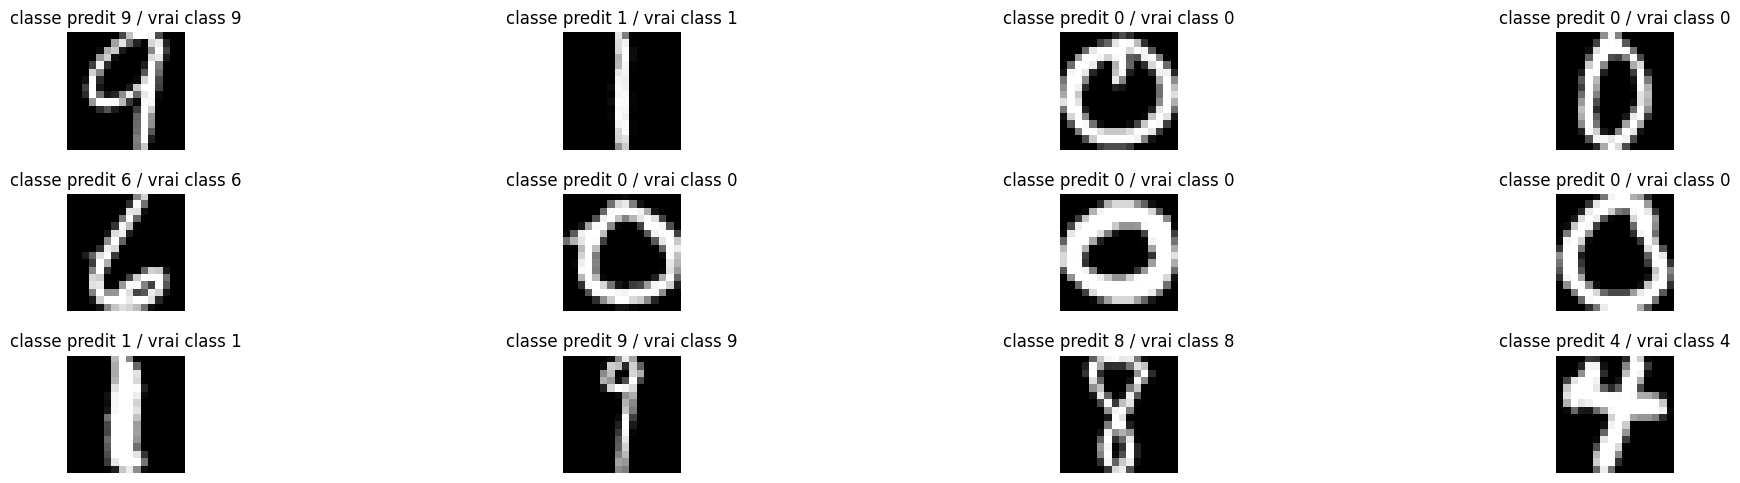

In [26]:
tools.print_image(testx,testy,net_128_64,12,16)

# auto encoder

### USPS data

In [3]:
path_train = "dataset/USPS_train.txt"
path_test = "dataset/USPS_test.txt"

trainx, train_y = tools.load_usps(path_train)
testx, test_y = tools.load_usps(path_test)

#### (2 couches: 1->100 2->10 )

In [10]:
# auto encdoder symertique

out1=100
out2=10

BCE_loss = BCELoss()
modul_lin1 = Linear( trainx.shape[1], out1)
modul_lin2 = Linear(out1, out2)
modul_lin3 = Linear( out2, out1)
modul_lin4 = Linear(out1, trainx.shape[1])

modul_lin3._parameters = modul_lin2._parameters.T
modul_lin4._parameters = modul_lin1._parameters.T

encoder=[modul_lin1,TanH(),modul_lin2,TanH()]
decoder=[modul_lin3,TanH(),modul_lin4,Sigmoide()]

encoder_100_10 = Sequentiel(encoder + decoder)

opt = Optim(encoder_100_10,BCE_loss,1e-4)
#stochastic
l_loss=opt.SGD(trainx,trainx,100,epochs=1000,shuffle=True)

100%|██████████| 1000/1000 [04:14<00:00,  3.93it/s]


#### reconstruction de données de test

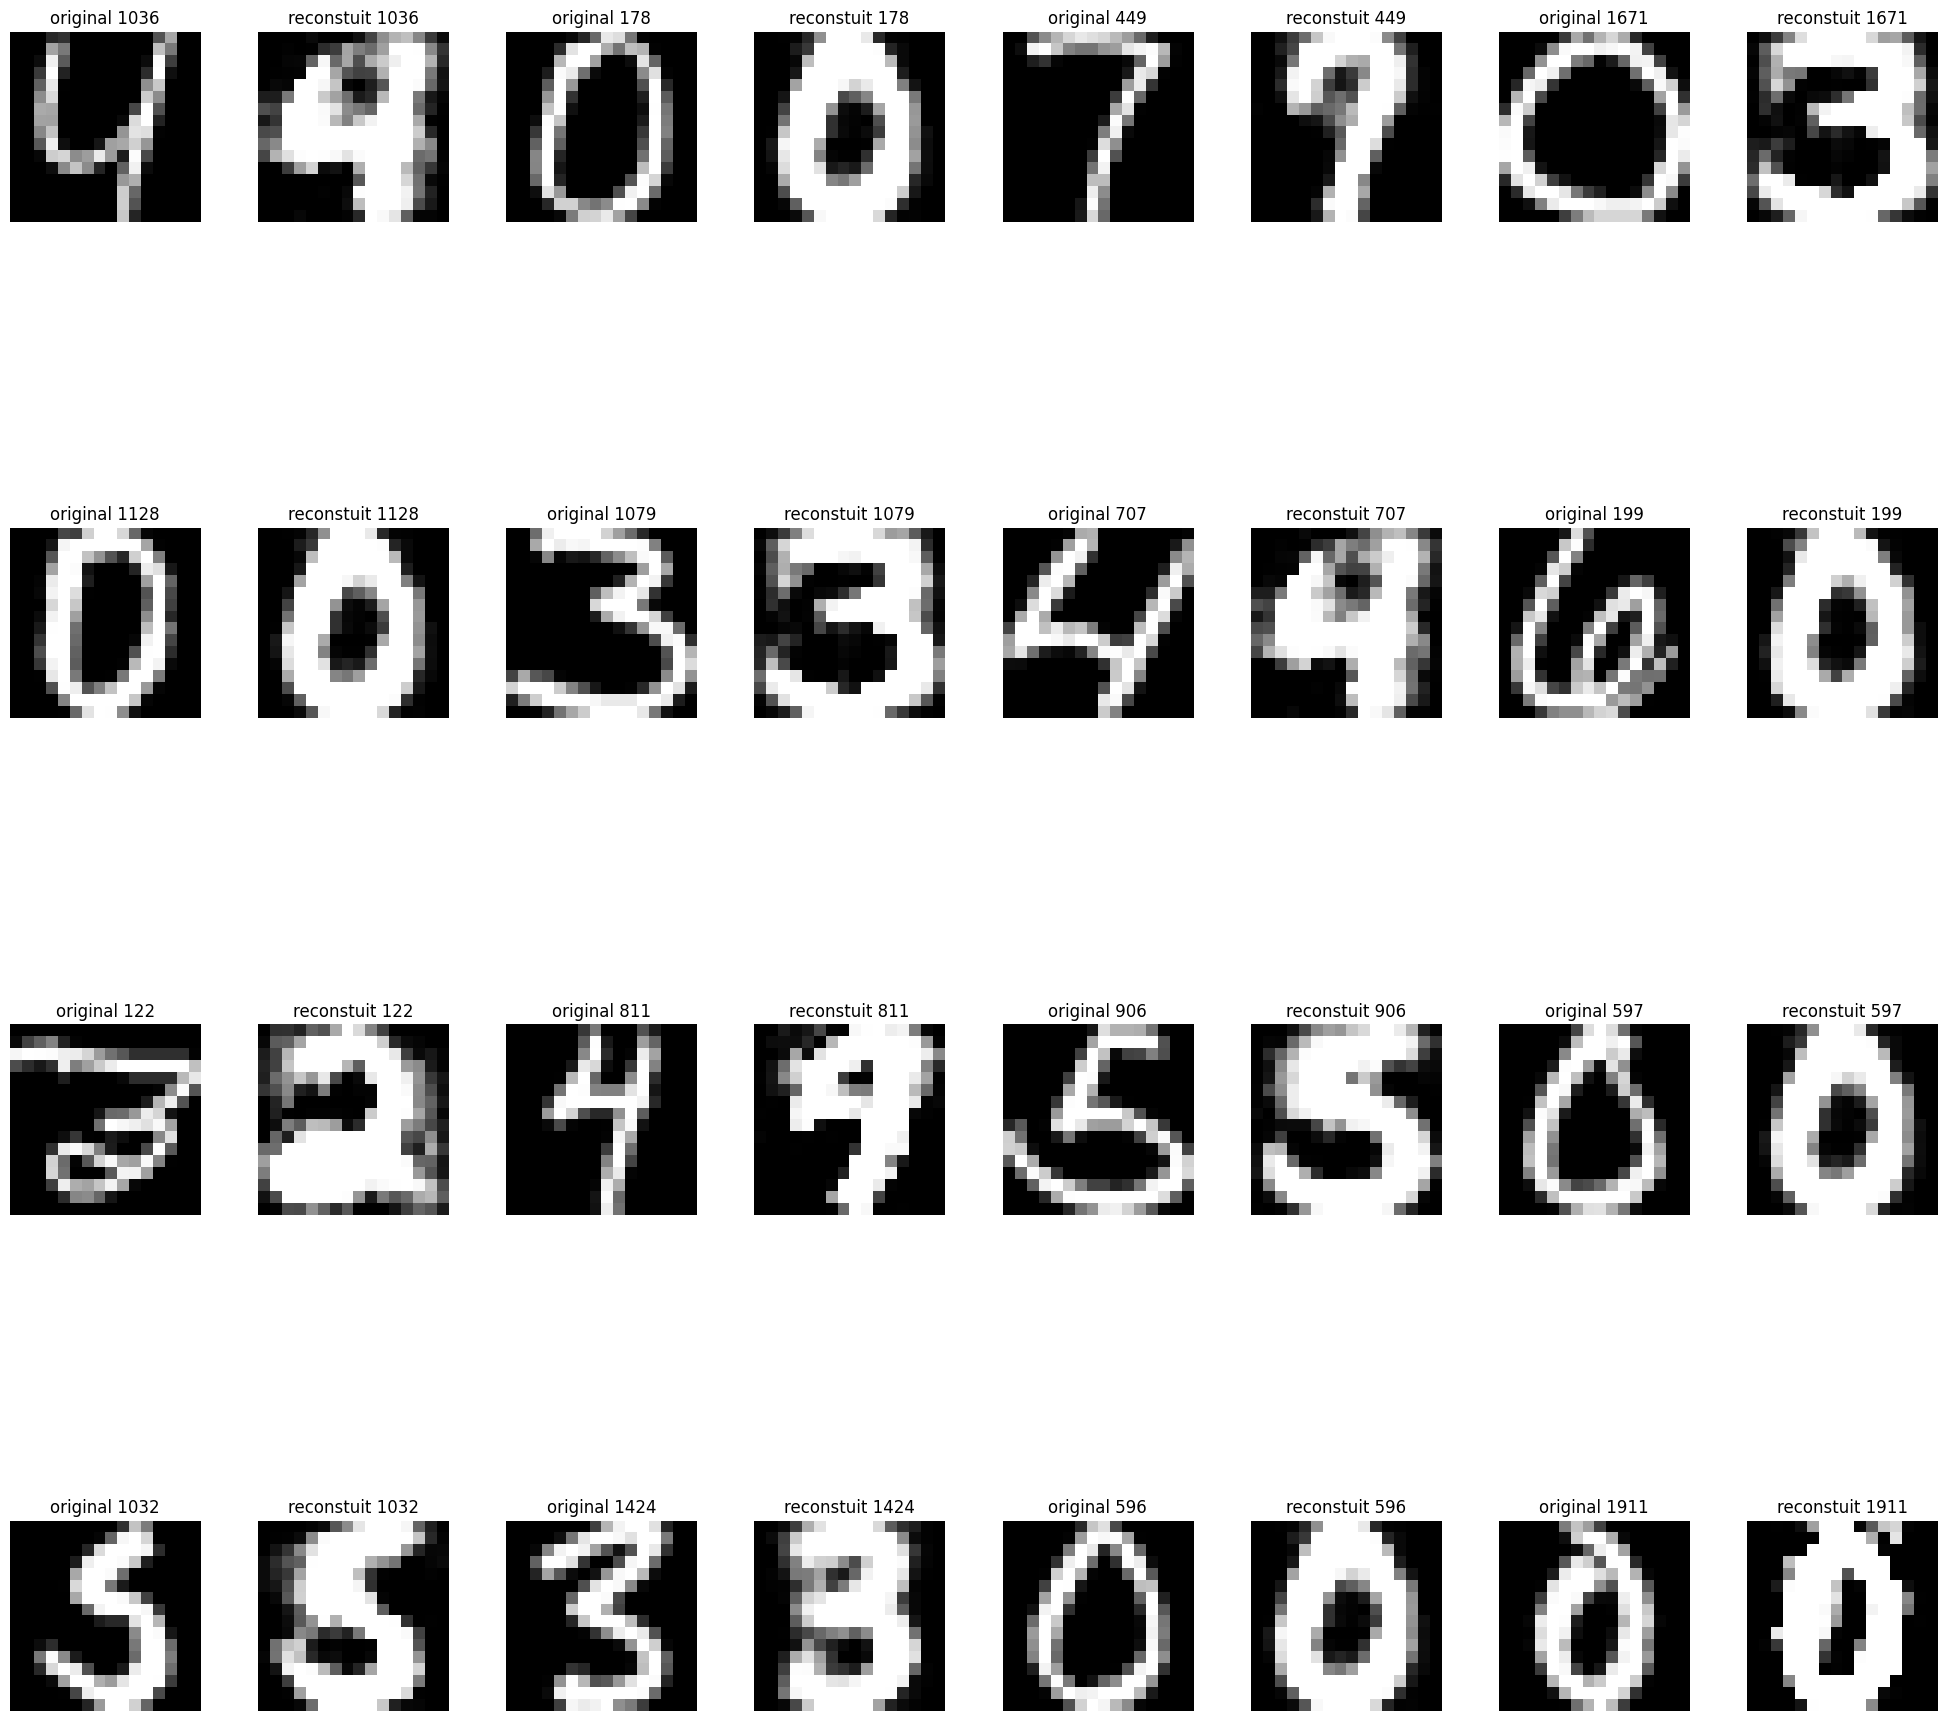

In [11]:
tools.print_auto_encoder(testx,encoder_100_10,16,16)

### MNIST data

In [13]:
X_train,Y_train,X_test,Y_test =tools.load_mist(50000,10000)

X_train_norm=X_train/255
X_test_norm=X_test/255

#### function d'activation TanH

##### (2 couches: 1->128 2->16 )

In [15]:
# auto encdoder symertique

out1=128
out2=16

BCE_loss = BCELoss()
modul_lin1_1 = Linear( X_train.shape[1], out1,type=1)
modul_lin2_1 = Linear(out1, out2,type=1)
modul_lin3_1 = Linear( out2, out1,type=1)
modul_lin4_1 = Linear(out1, X_train.shape[1],type=1)

modul_lin3_1._parameters = modul_lin2_1._parameters.T
modul_lin4_1._parameters = modul_lin1_1._parameters.T

encoder_128_16=[modul_lin1_1,TanH(),modul_lin2_1,TanH()]
decoder_128_16=[modul_lin3_1,TanH(),modul_lin4_1,Sigmoide()]

net_enc_128_16 = Sequentiel(encoder_128_16 + decoder_128_16)

opt = Optim(net_enc_128_16,BCE_loss,1e-4)
l=opt.SGD(X_train_norm,X_train_norm,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [15:48<00:00,  4.74s/it]


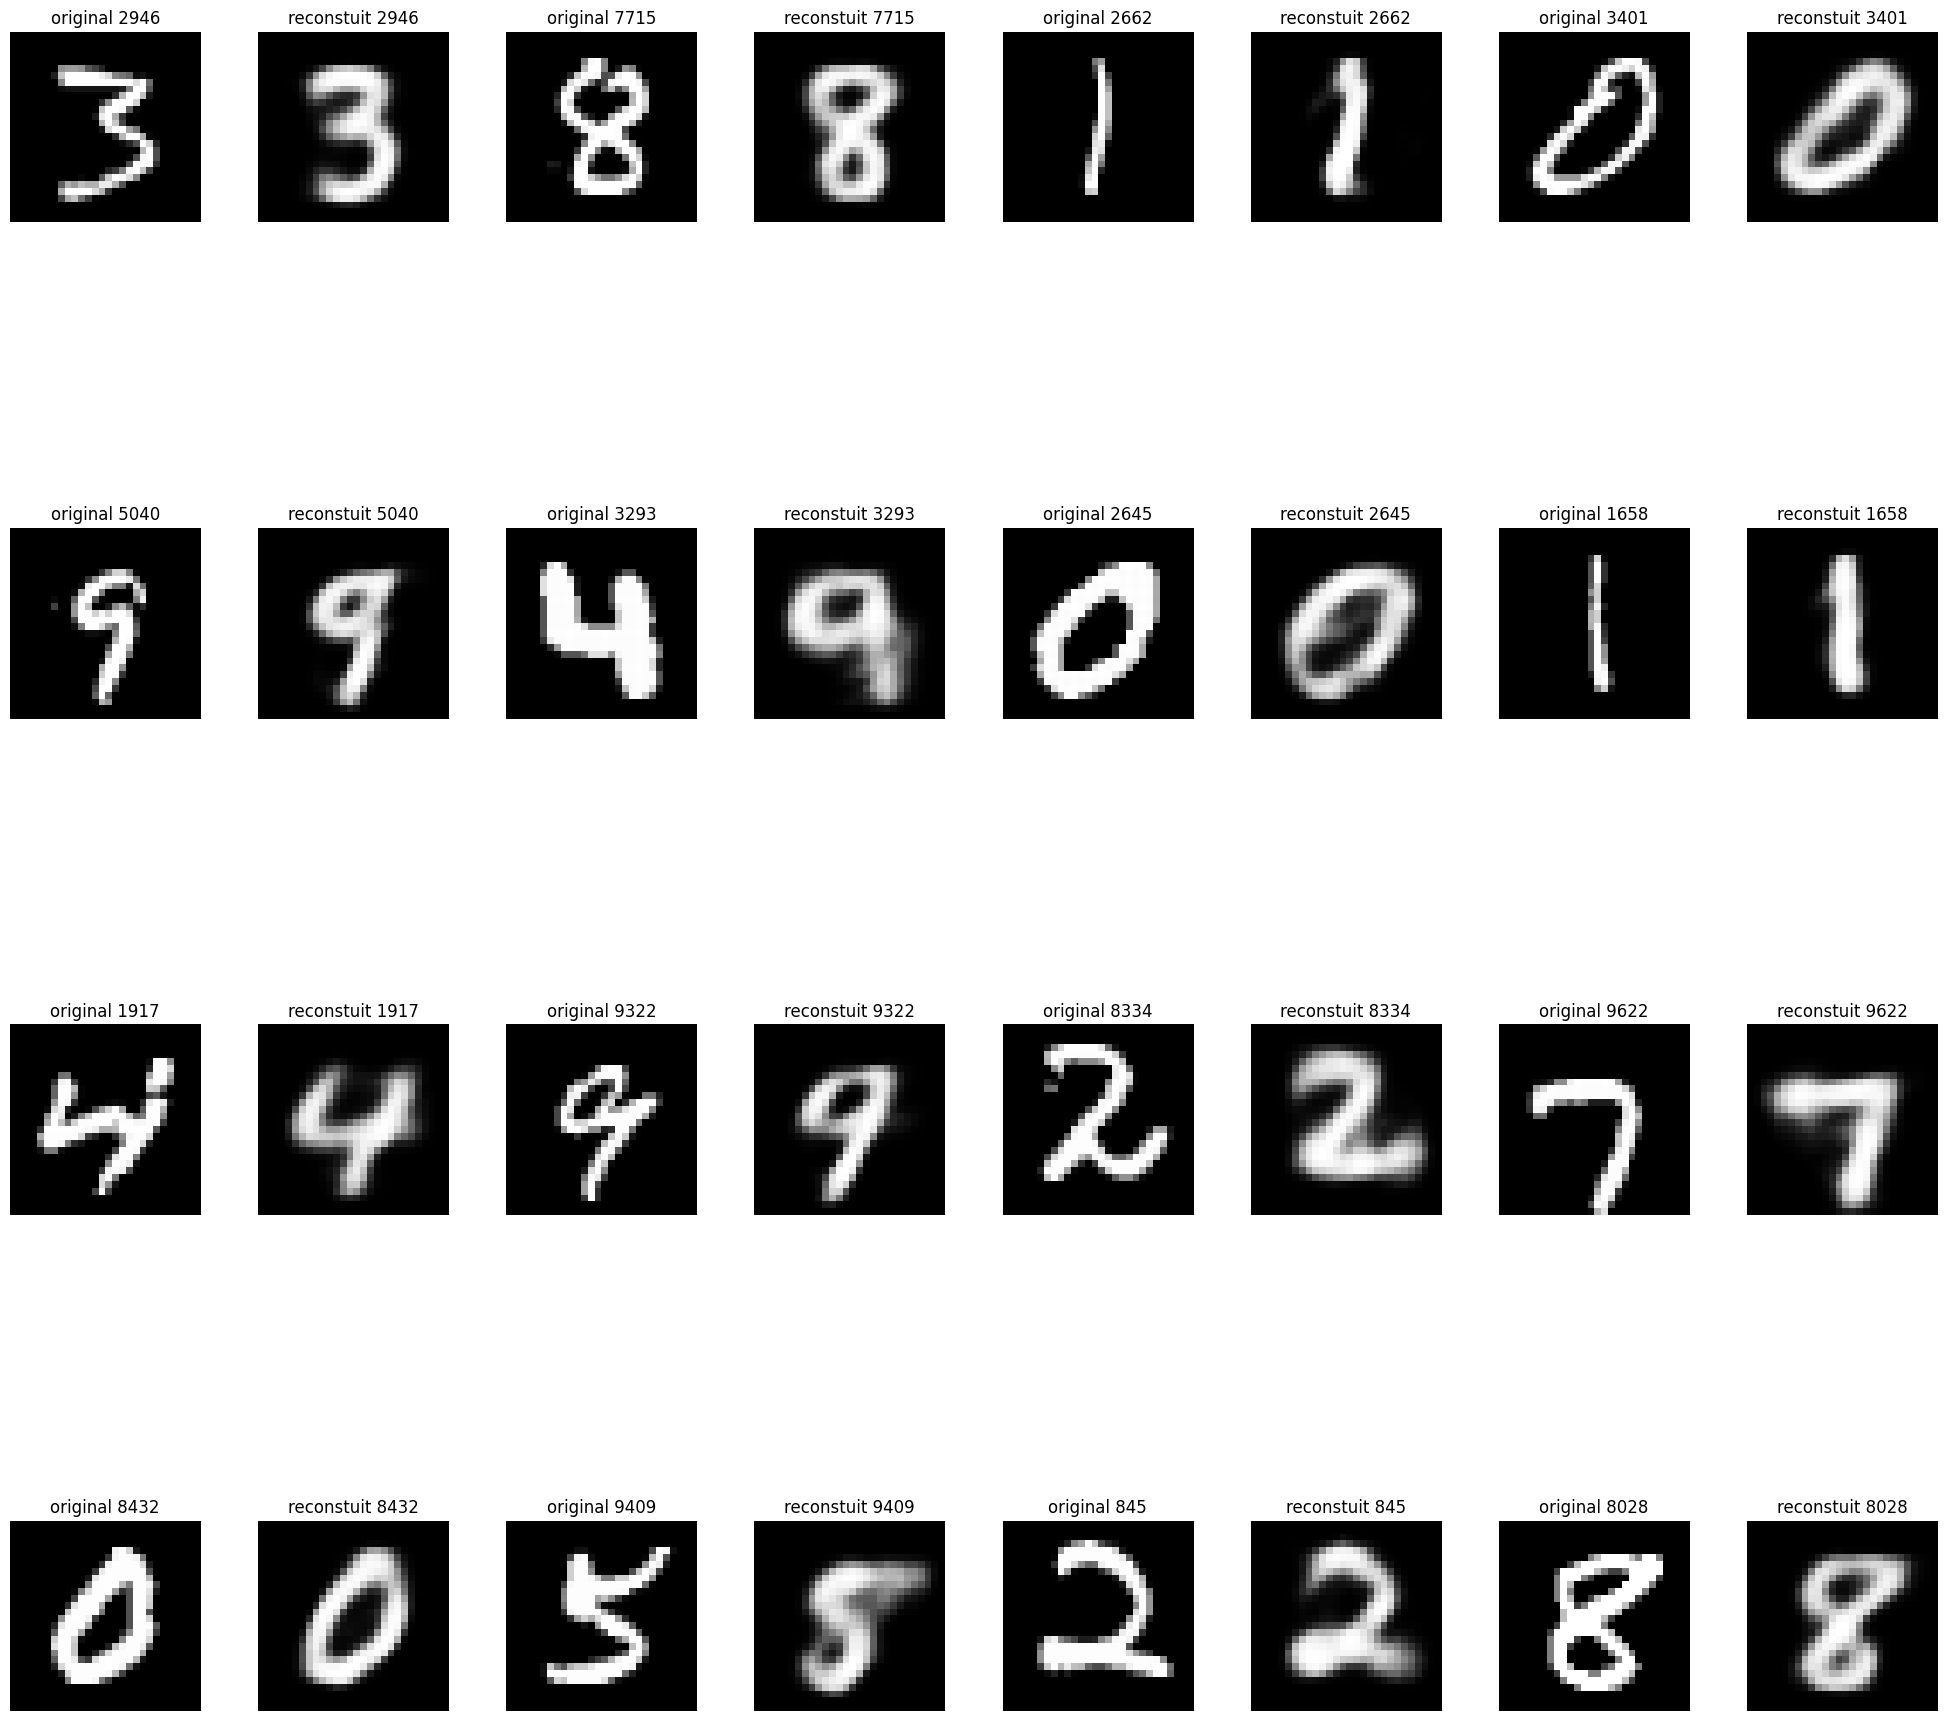

In [27]:
tools.print_auto_encoder(X_test,net_enc_128_16,16,28)

##### (2 couches: 1->256 2->2 )

In [18]:
# auto encdoder symertique

out1=256
out2=2

BCE_loss = BCELoss()
modul_lin1_2 = Linear( X_train.shape[1], out1,type=1)
modul_lin2_2 = Linear(out1, out2,type=1)
modul_lin3_2 = Linear( out2, out1,type=1)
modul_lin4_2 = Linear(out1, X_train.shape[1],type=1)

modul_lin3_2._parameters = modul_lin2_2._parameters.T
modul_lin4_2._parameters = modul_lin1_2._parameters.T

encoder_256_2=[modul_lin1_2,TanH(),modul_lin2_2,TanH()]
decoder_256_2=[modul_lin3_2,TanH(),modul_lin4_2,Sigmoide()]

net_enc_256_2 = Sequentiel(encoder_256_2 + decoder_256_2)

opt = Optim(net_enc_256_2,BCE_loss,1e-4)
l=opt.SGD(X_train_norm,X_train_norm,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [27:05<00:00,  8.13s/it]


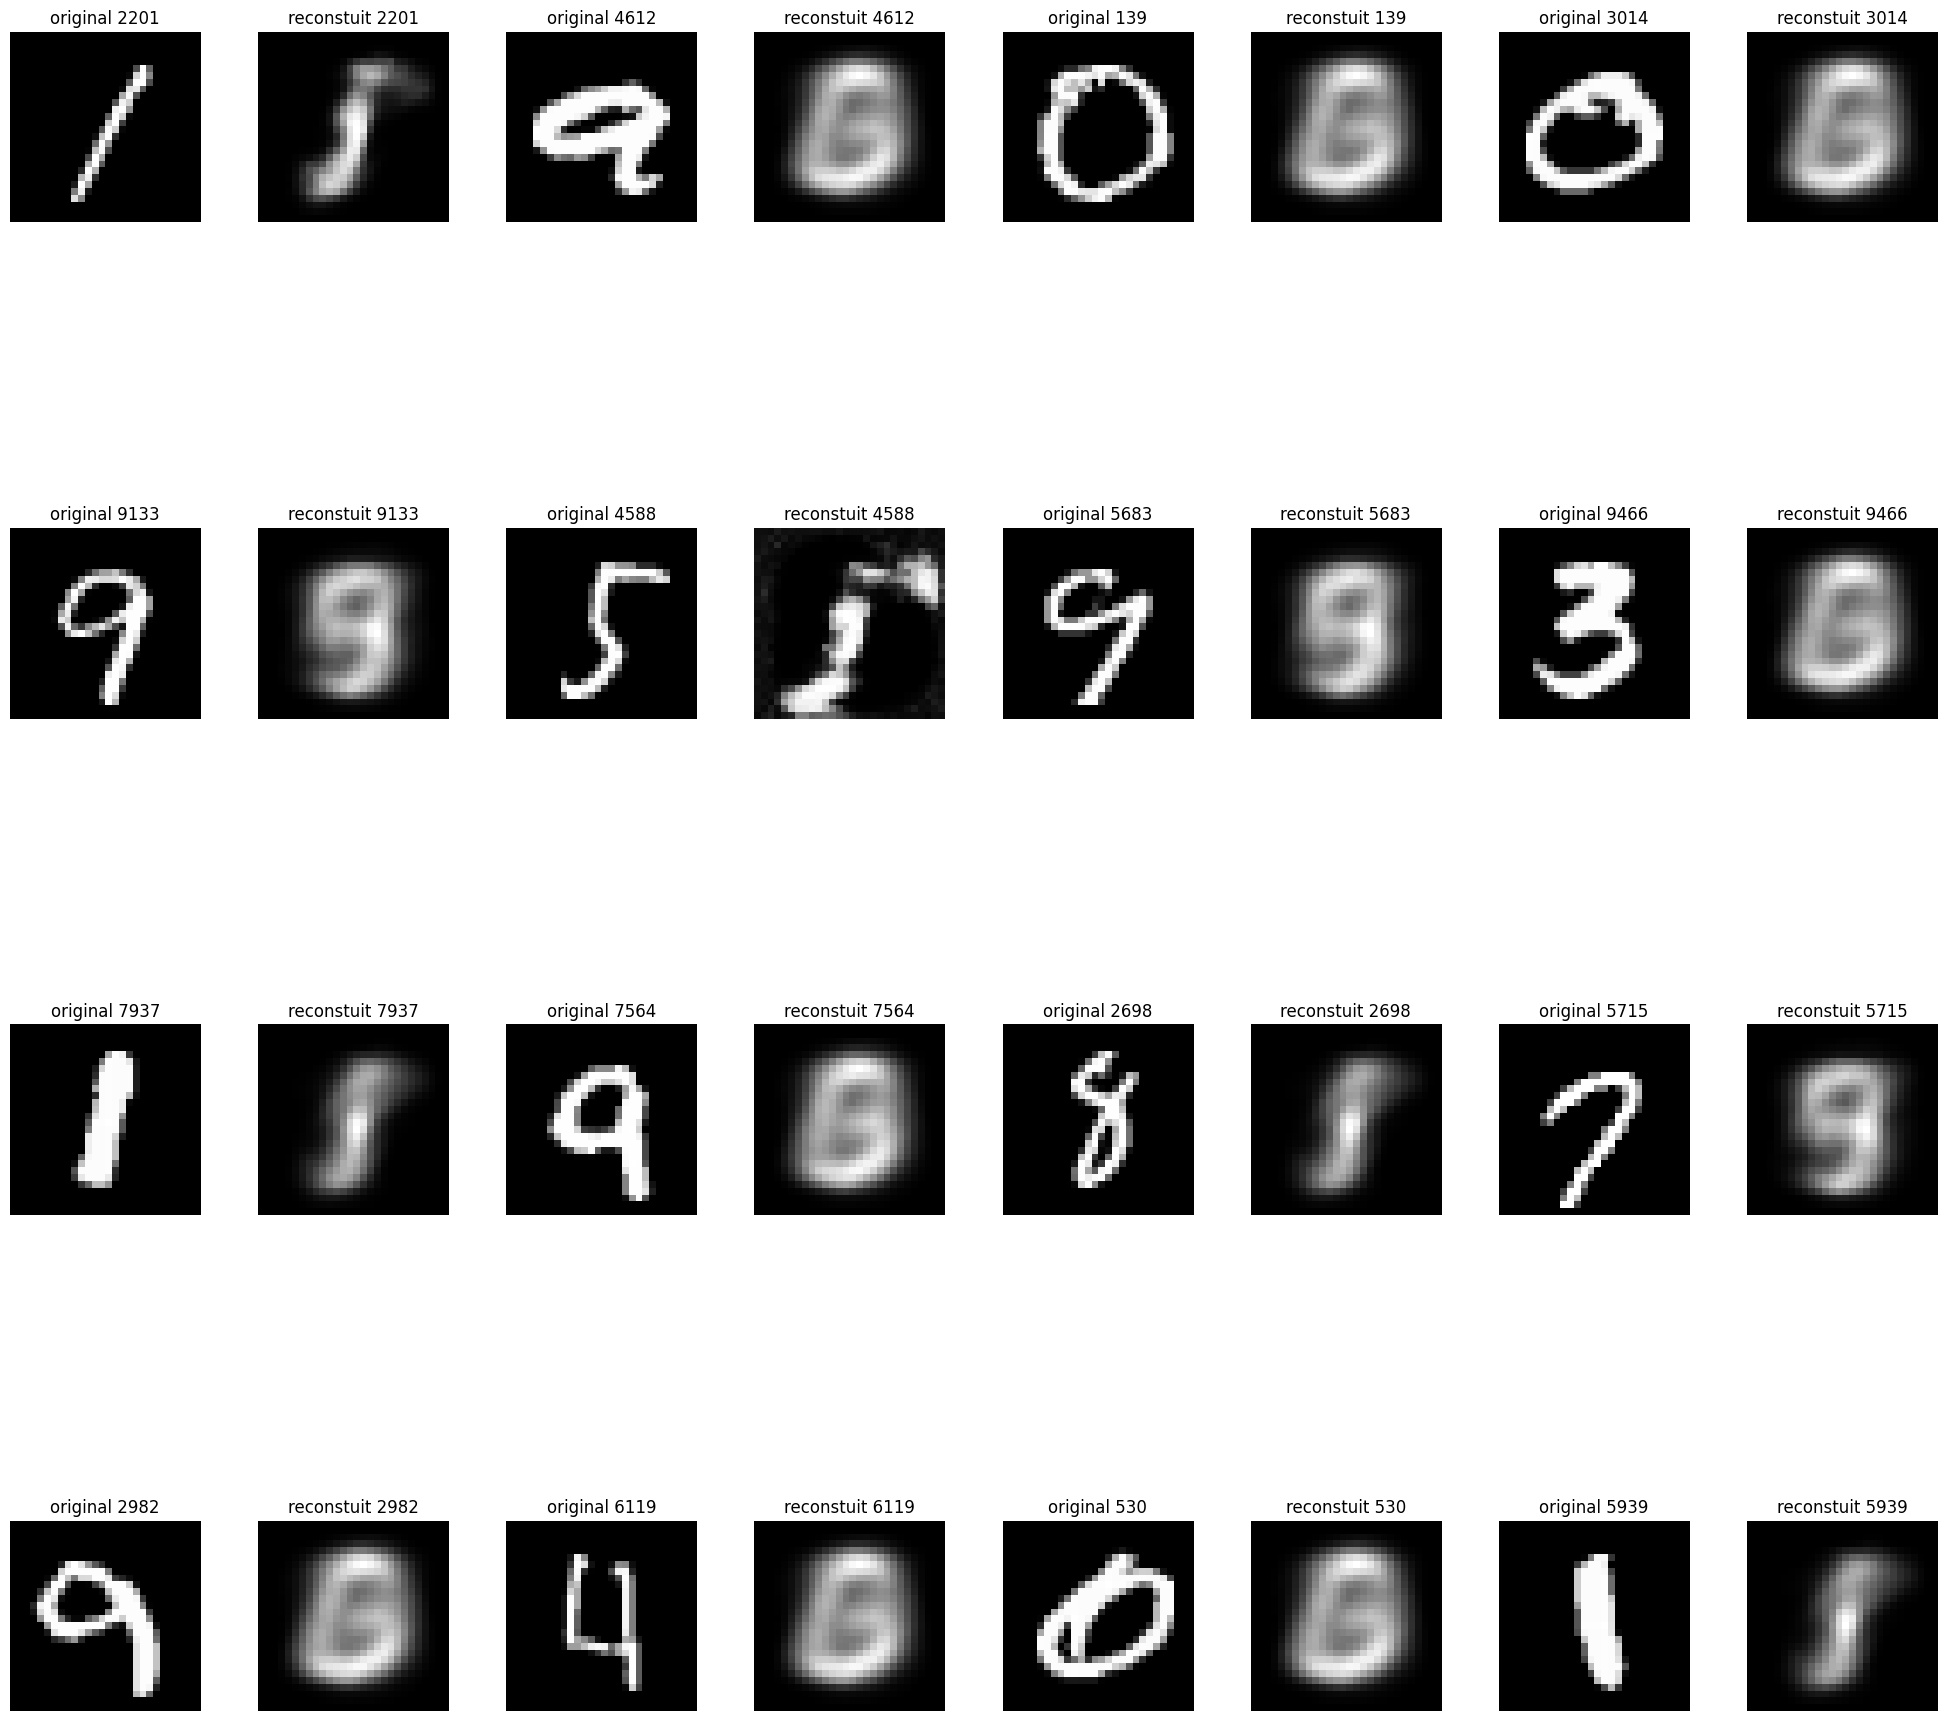

In [22]:
tools.print_auto_encoder(X_test,net_enc_256_2,16,28)

##### (3 couches: 1->256 2->128 3->16 ) 

In [20]:
# auto encdoder symertique

out1=256
out2=128
out3=16

BCE_loss = BCELoss()
modul_lin1_3 = Linear( X_train.shape[1], out1,type=1)
modul_lin2_3 = Linear(out1, out2,type=1)
modul_lin3_3 = Linear( out2, out3,type=1)
modul_lin4_3 = Linear( out3, out2,type=1)
modul_lin5_3 = Linear(out2, out1,type=1)
modul_lin6_3 = Linear(out1, X_train.shape[1],type=1)


modul_lin6_3._parameters = modul_lin1_3._parameters.T
modul_lin5_3._parameters = modul_lin2_3._parameters.T
modul_lin4_3._parameters = modul_lin3_3._parameters.T

encoder_256_128_16=[modul_lin1_3,TanH(),modul_lin2_3,TanH(),modul_lin3_3,TanH()]
decoder_256_128_16=[modul_lin4_3,TanH(),modul_lin5_3,TanH(),modul_lin6_3,Sigmoide()]

net_enc_256_128_16 = Sequentiel(encoder_256_128_16 + decoder_256_128_16)

opt = Optim(net_enc_256_128_16,BCE_loss,1e-4)
l=opt.SGD(X_train_norm,X_train_norm,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [32:18<00:00,  9.69s/it]


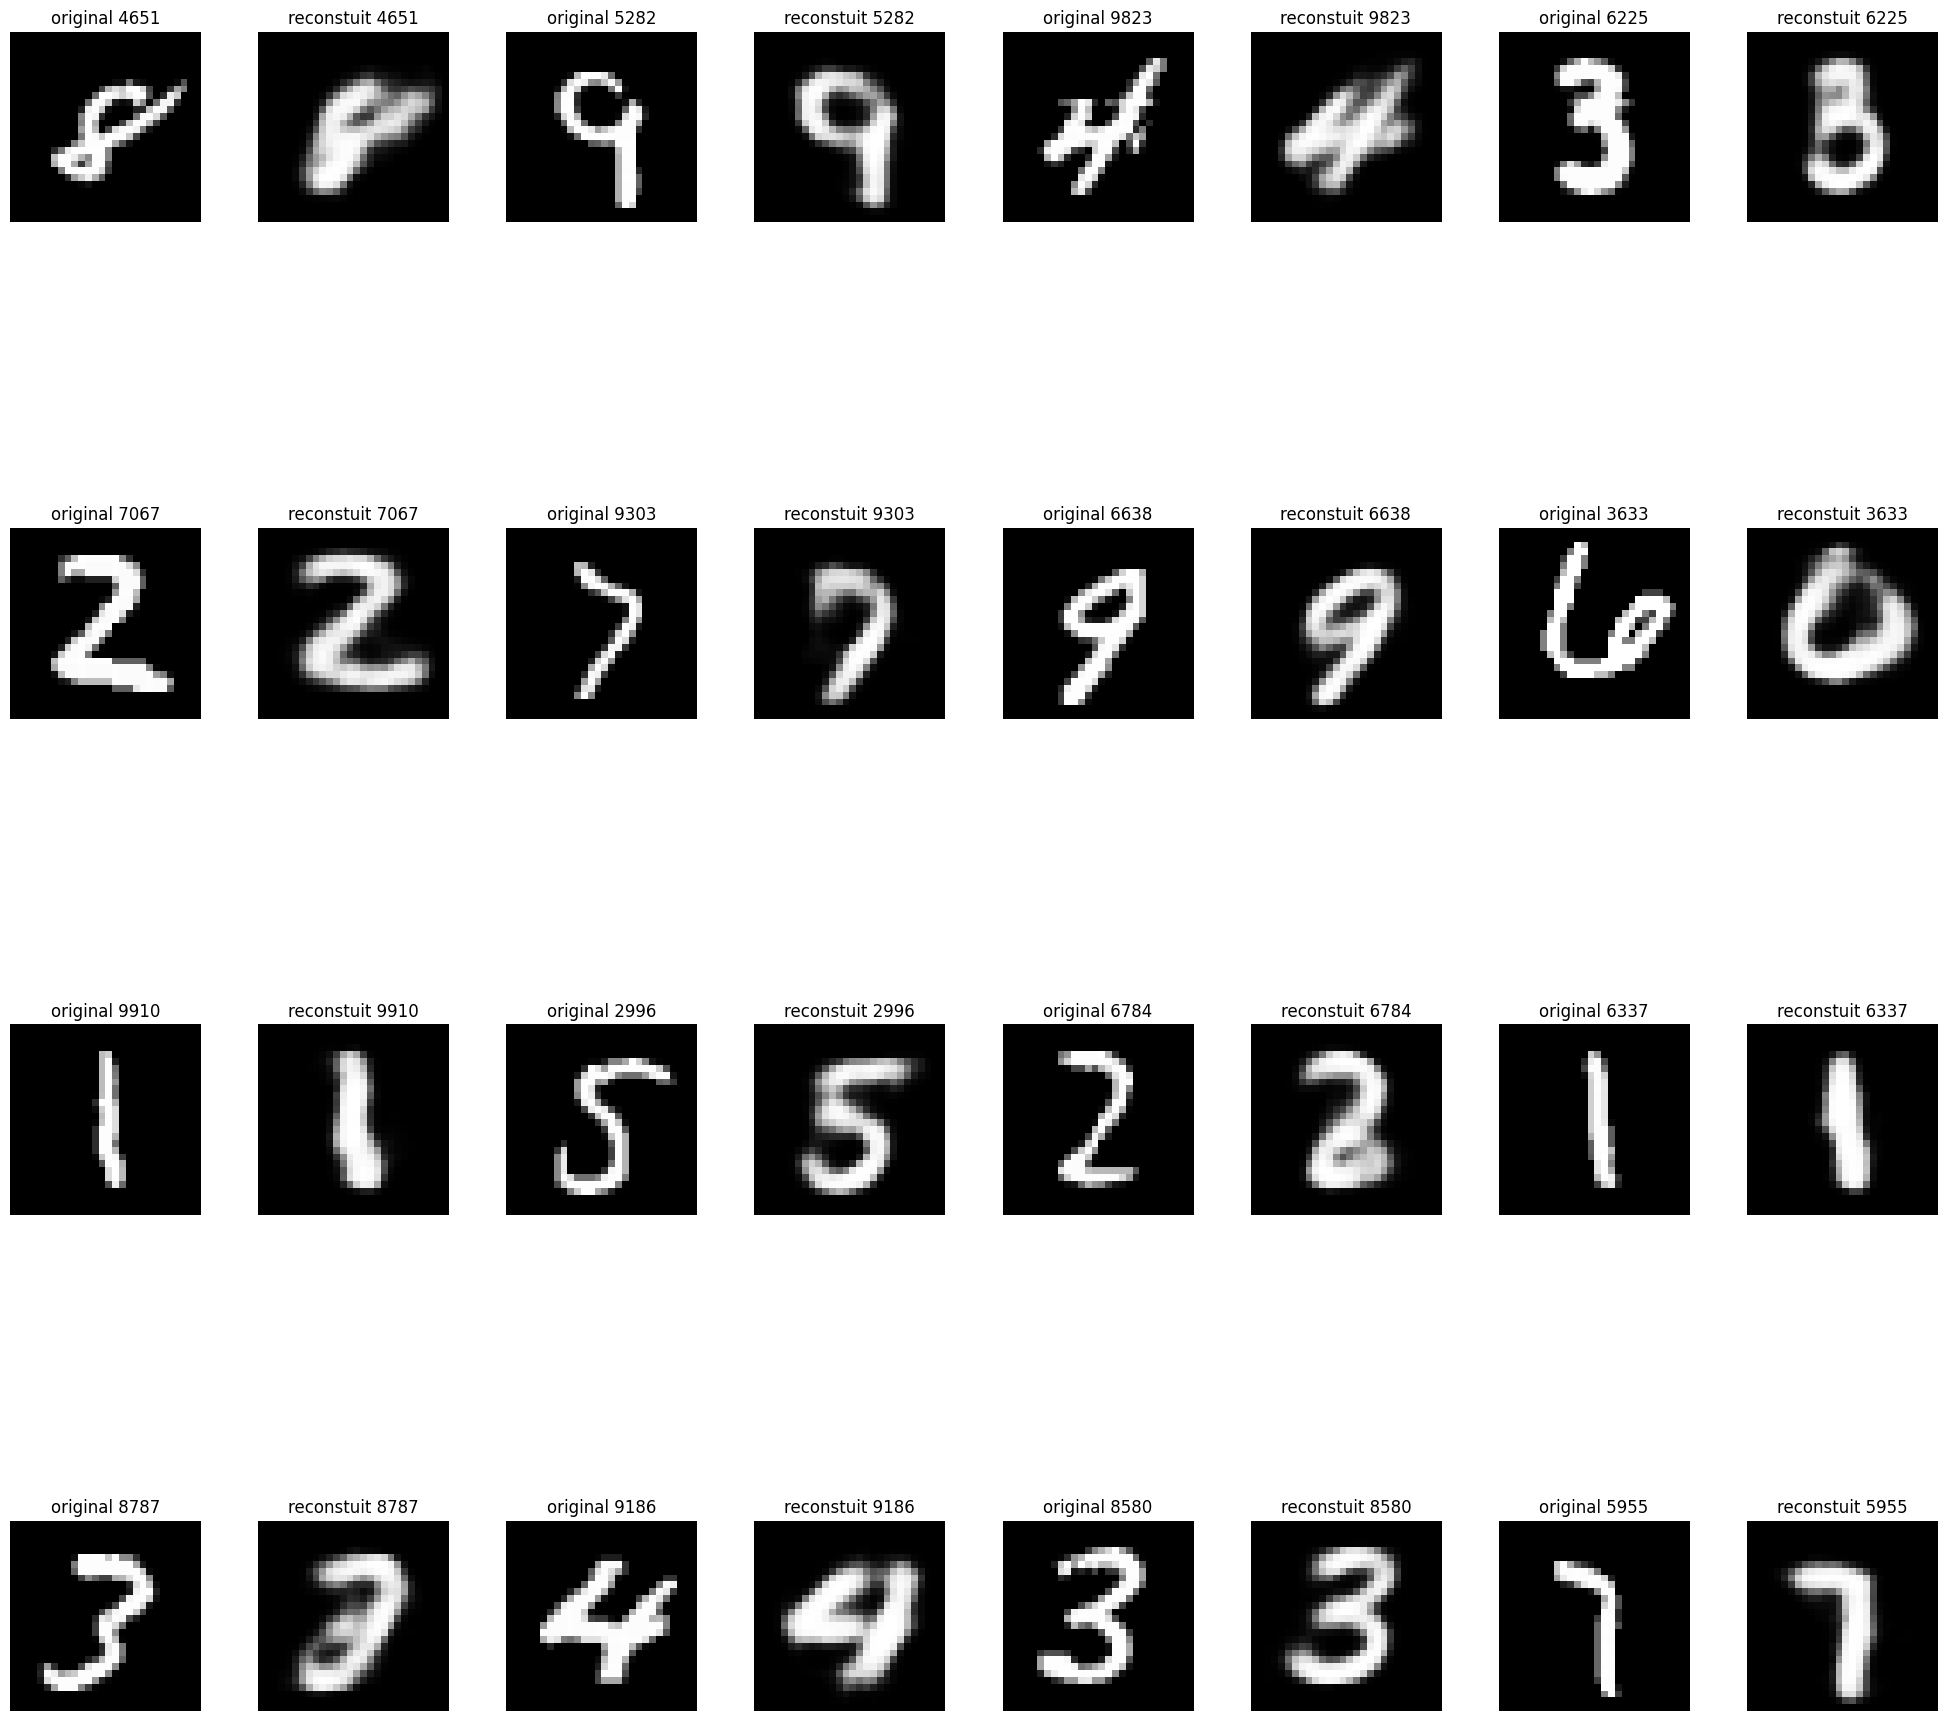

In [21]:
tools.print_auto_encoder(X_test,net_enc_256_128_16,16,28)

##### (3 couches: 1->512 2->256 3->2 ) 

In [24]:
# auto encdoder symertique

out1=512
out2=256
out3=2

BCE_loss = BCELoss()
modul_lin1_4 = Linear( X_train.shape[1], out1,type=1)
modul_lin2_4 = Linear(out1, out2,type=1)
modul_lin3_4 = Linear( out2, out3,type=1)
modul_lin4_4 = Linear( out3, out2,type=1)
modul_lin5_4 = Linear(out2, out1,type=1)
modul_lin6_4 = Linear(out1, X_train.shape[1],type=1)


modul_lin6_4._parameters = modul_lin1_4._parameters.T
modul_lin5_4._parameters = modul_lin2_4._parameters.T
modul_lin4_4._parameters = modul_lin3_4._parameters.T

encoder_512_256_2=[modul_lin1_4,TanH(),modul_lin2_4,TanH(),modul_lin3_4,TanH()]
decoder_512_256_2=[modul_lin4_4,TanH(),modul_lin5_4,TanH(),modul_lin6_4,Sigmoide()]

net_enc_512_256_2 = Sequentiel(encoder_512_256_2 + decoder_512_256_2)

opt = Optim(net_enc_512_256_2,BCE_loss,1e-4)
l=opt.SGD(X_train_norm,X_train_norm,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [50:44<00:00, 15.22s/it]


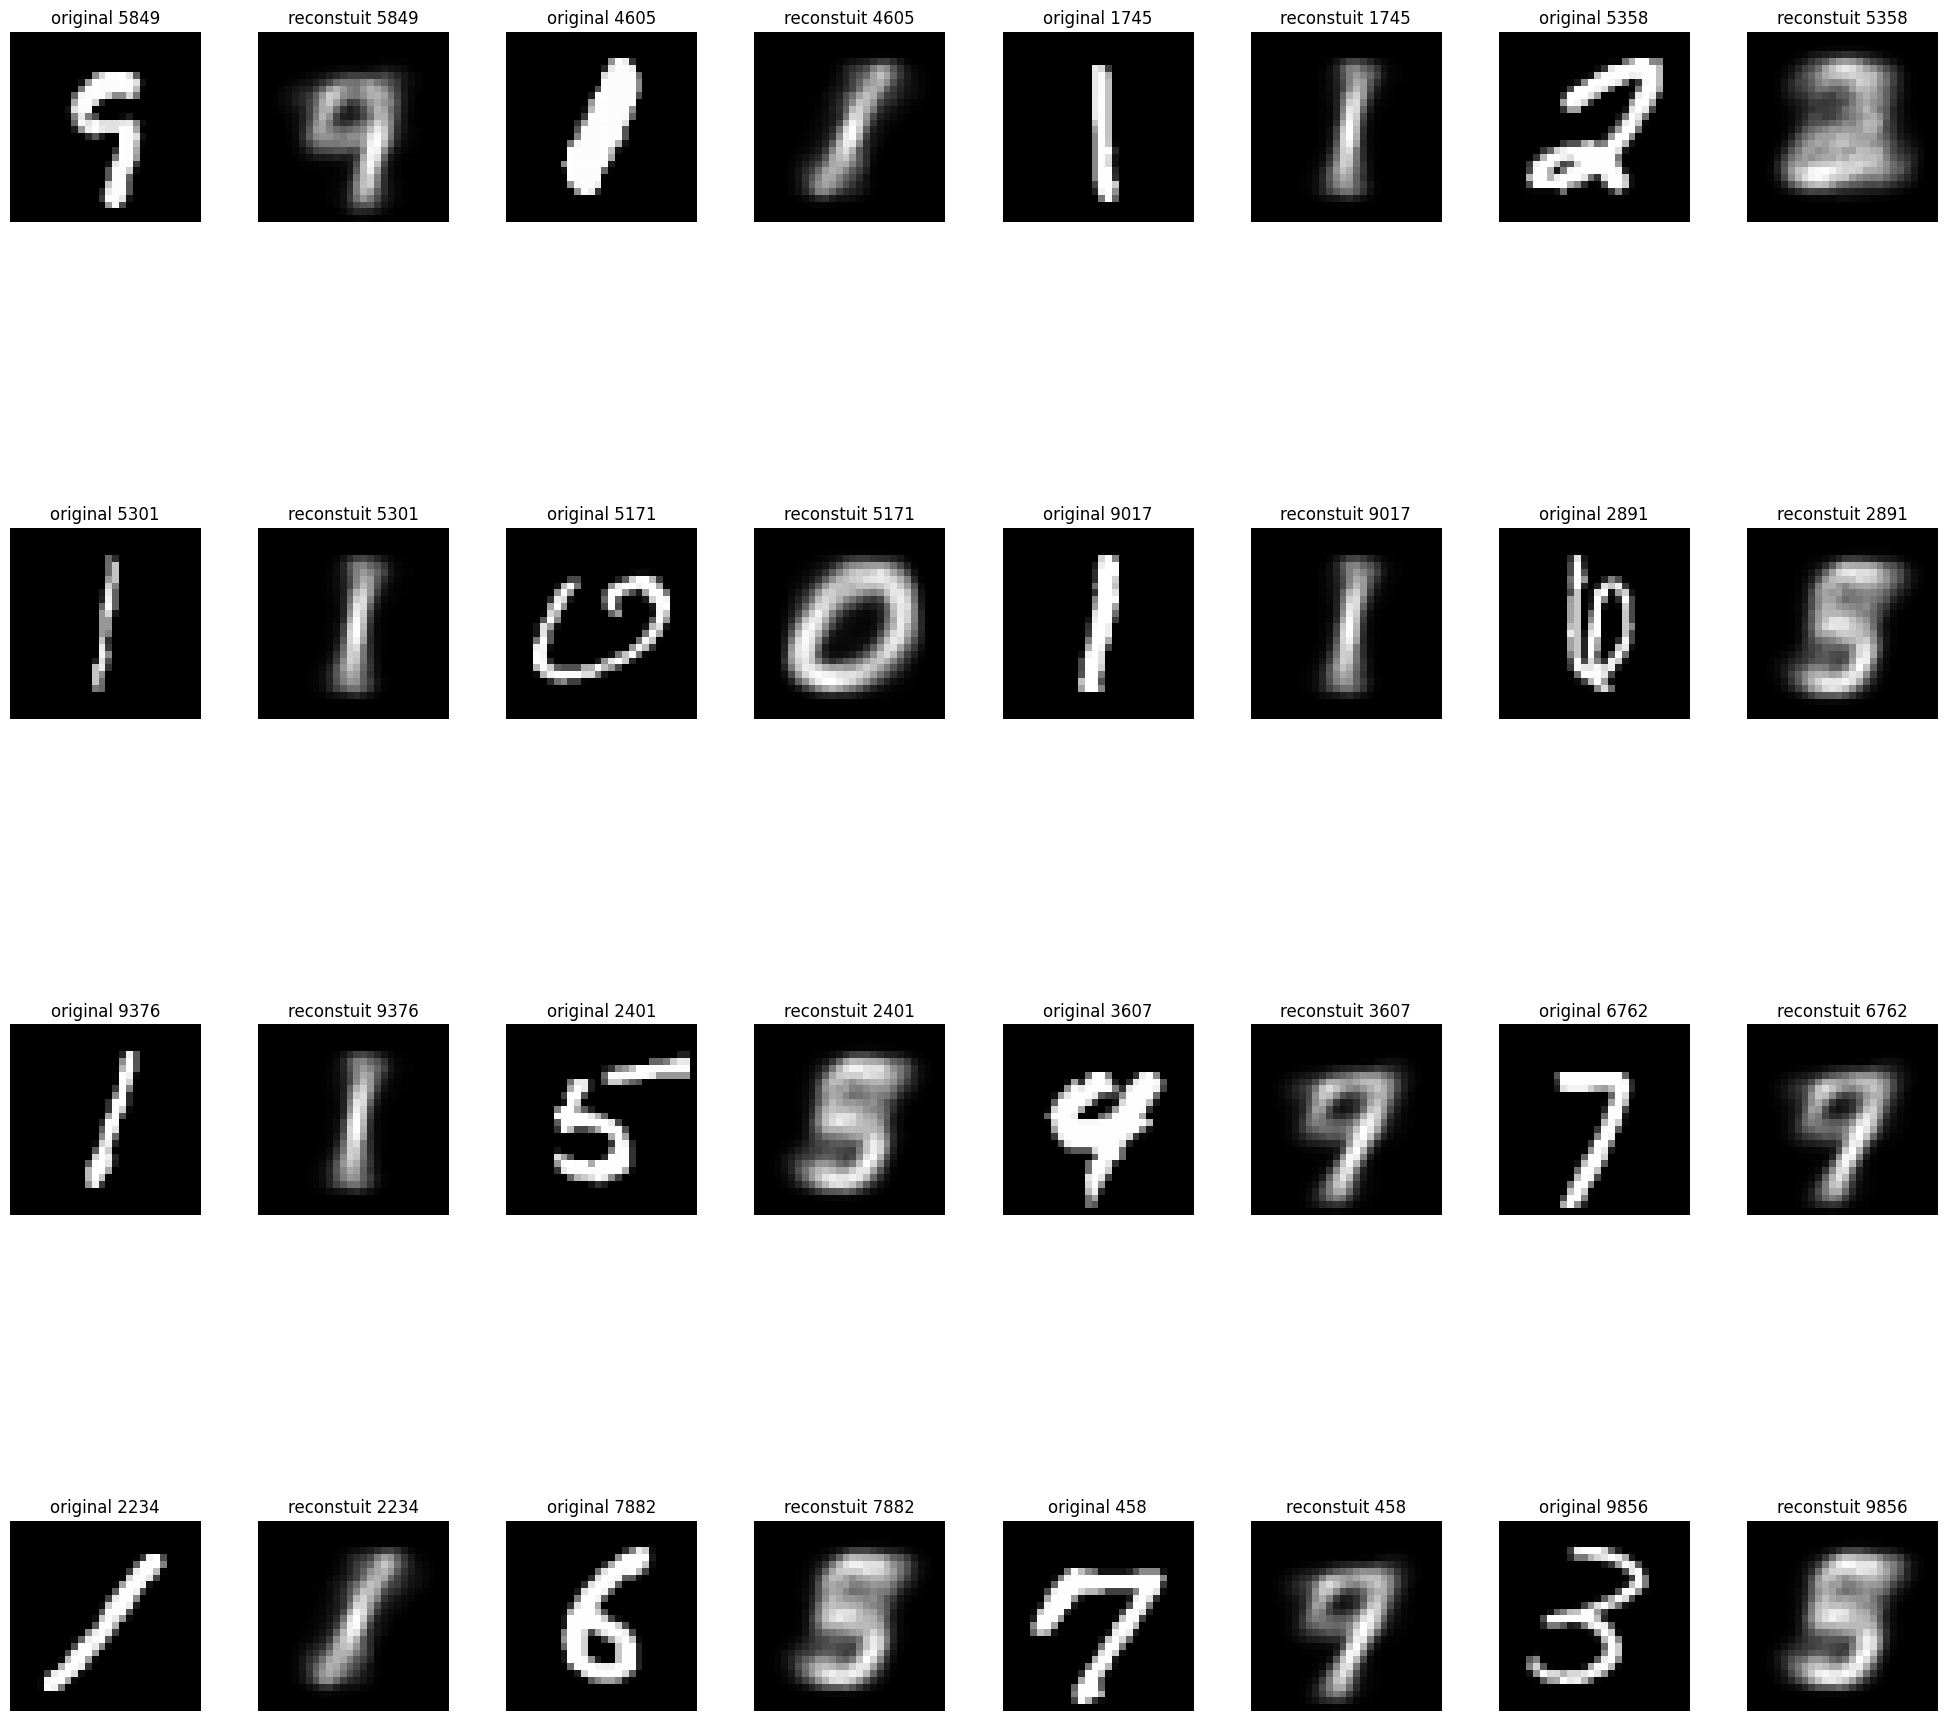

In [25]:
tools.print_auto_encoder(X_test,net_enc_512_256_2,16,28)

#### function d'activation ReLU

##### (2 couches: 1->128 2->16 )

In [28]:
# auto encdoder symertique

out1=128
out2=16

BCE_loss = BCELoss()
modul_lin1_1_relu = Linear( X_train.shape[1], out1,type=1)
modul_lin2_1_relu = Linear(out1, out2,type=1)
modul_lin3_1_relu = Linear( out2, out1,type=1)
modul_lin4_1_relu = Linear(out1, X_train.shape[1],type=1)

modul_lin3_1_relu._parameters = modul_lin2_1_relu._parameters.T
modul_lin4_1_relu._parameters = modul_lin1_1_relu._parameters.T

encoder_128_16_relu=[modul_lin1_1_relu,ReLU(),modul_lin2_1_relu,ReLU()]
decoder_128_16_relu=[modul_lin3_1_relu,ReLU(),modul_lin4_1_relu,Sigmoide()]

net_enc_128_16_relu = Sequentiel(encoder_128_16_relu + decoder_128_16_relu)

opt = Optim(net_enc_128_16_relu,BCE_loss,1e-4)
l=opt.SGD(X_train_norm,X_train_norm,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [15:36<00:00,  4.68s/it]


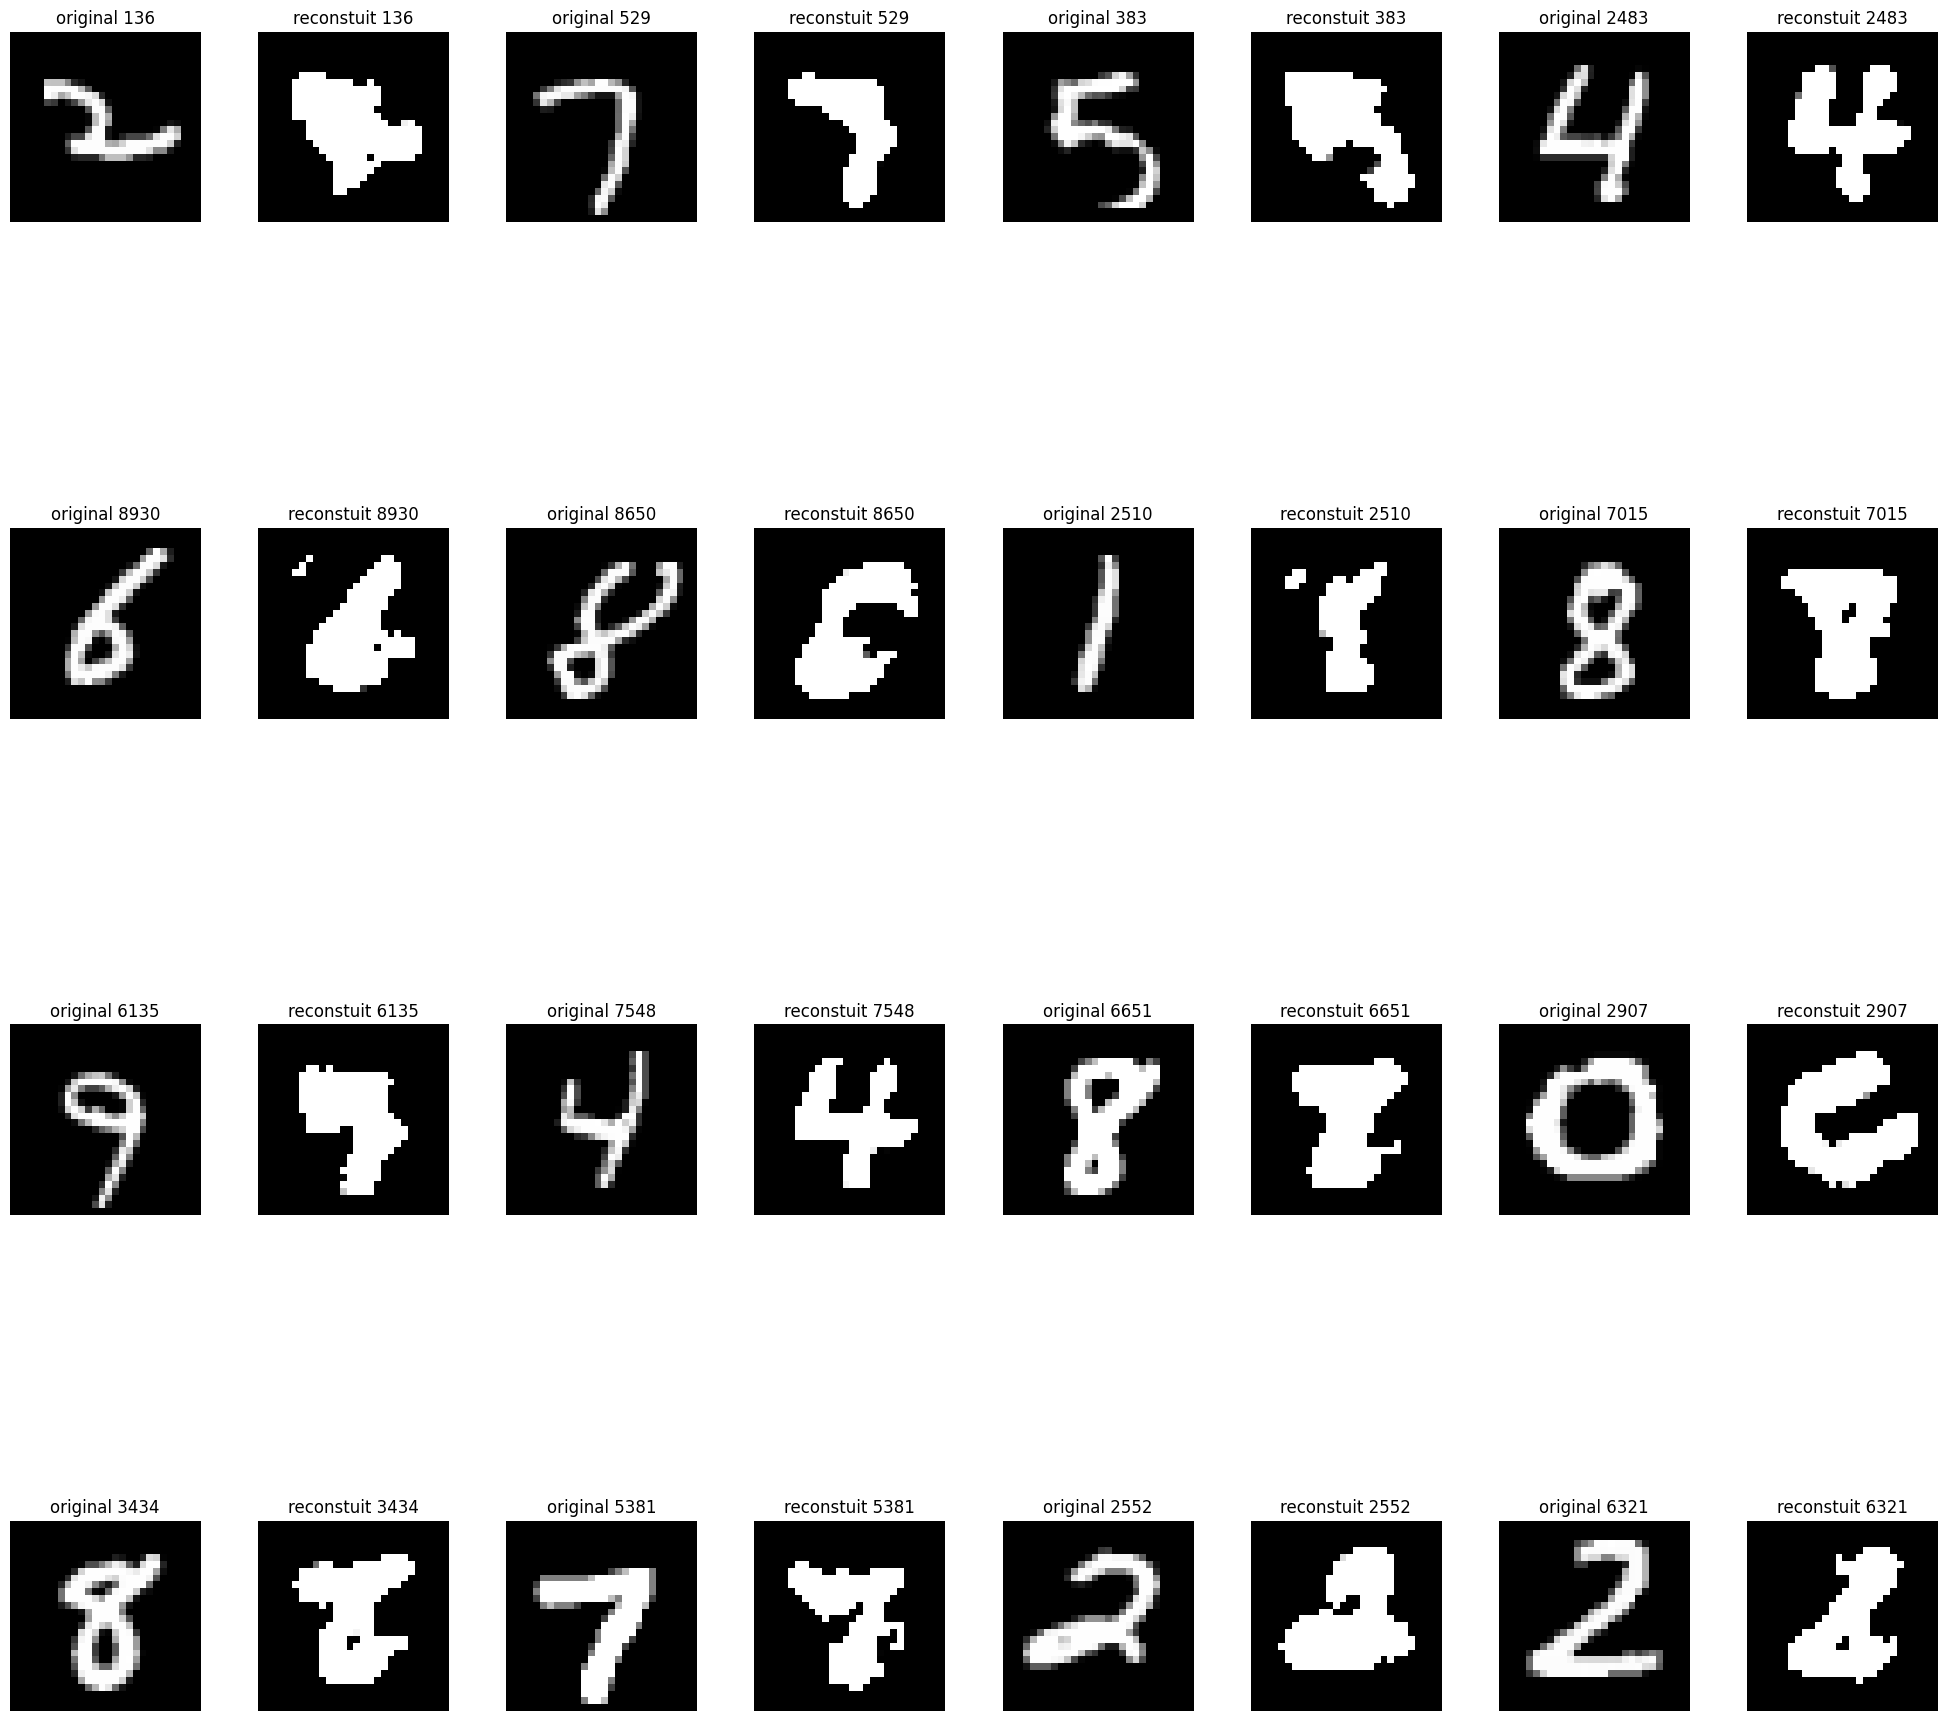

In [31]:
tools.print_auto_encoder(X_test,net_enc_128_16_relu,16,28)

##### (3 couches: 1->256 2->128 3->16 ) 

In [35]:
# auto encdoder symertique

out1=256
out2=128
out3=16

BCE_loss = BCELoss()
modul_lin1_3_relu = Linear( X_train.shape[1], out1,type=1)
modul_lin2_3_relu = Linear(out1, out2,type=1)
modul_lin3_3_relu = Linear( out2, out3,type=1)
modul_lin4_3_relu = Linear( out3, out2,type=1)
modul_lin5_3_relu = Linear(out2, out1,type=1)
modul_lin6_3_relu = Linear(out1, X_train.shape[1],type=1)


modul_lin6_3_relu._parameters = modul_lin1_3_relu._parameters.T
modul_lin5_3_relu._parameters = modul_lin2_3_relu._parameters.T
modul_lin4_3_relu._parameters = modul_lin3_3_relu._parameters.T

encoder_256_128_16_relu=[modul_lin1_3_relu,ReLU(),modul_lin2_3_relu,ReLU(),modul_lin3_3_relu,ReLU()]
decoder_256_128_16_relu=[modul_lin4_3_relu,ReLU(),modul_lin5_3_relu,ReLU(),modul_lin6_3_relu,Sigmoide()]

net_enc_256_128_16_relu = Sequentiel(encoder_256_128_16_relu + decoder_256_128_16_relu)

opt = Optim(net_enc_256_128_16_relu,BCE_loss,1e-4)
l=opt.SGD(X_train_norm,X_train_norm,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [24:22<00:00,  7.31s/it]


/home/raouf/M1/S2/ML/TP/neural_network_from_scratch/./src/non_lineare.py:18: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


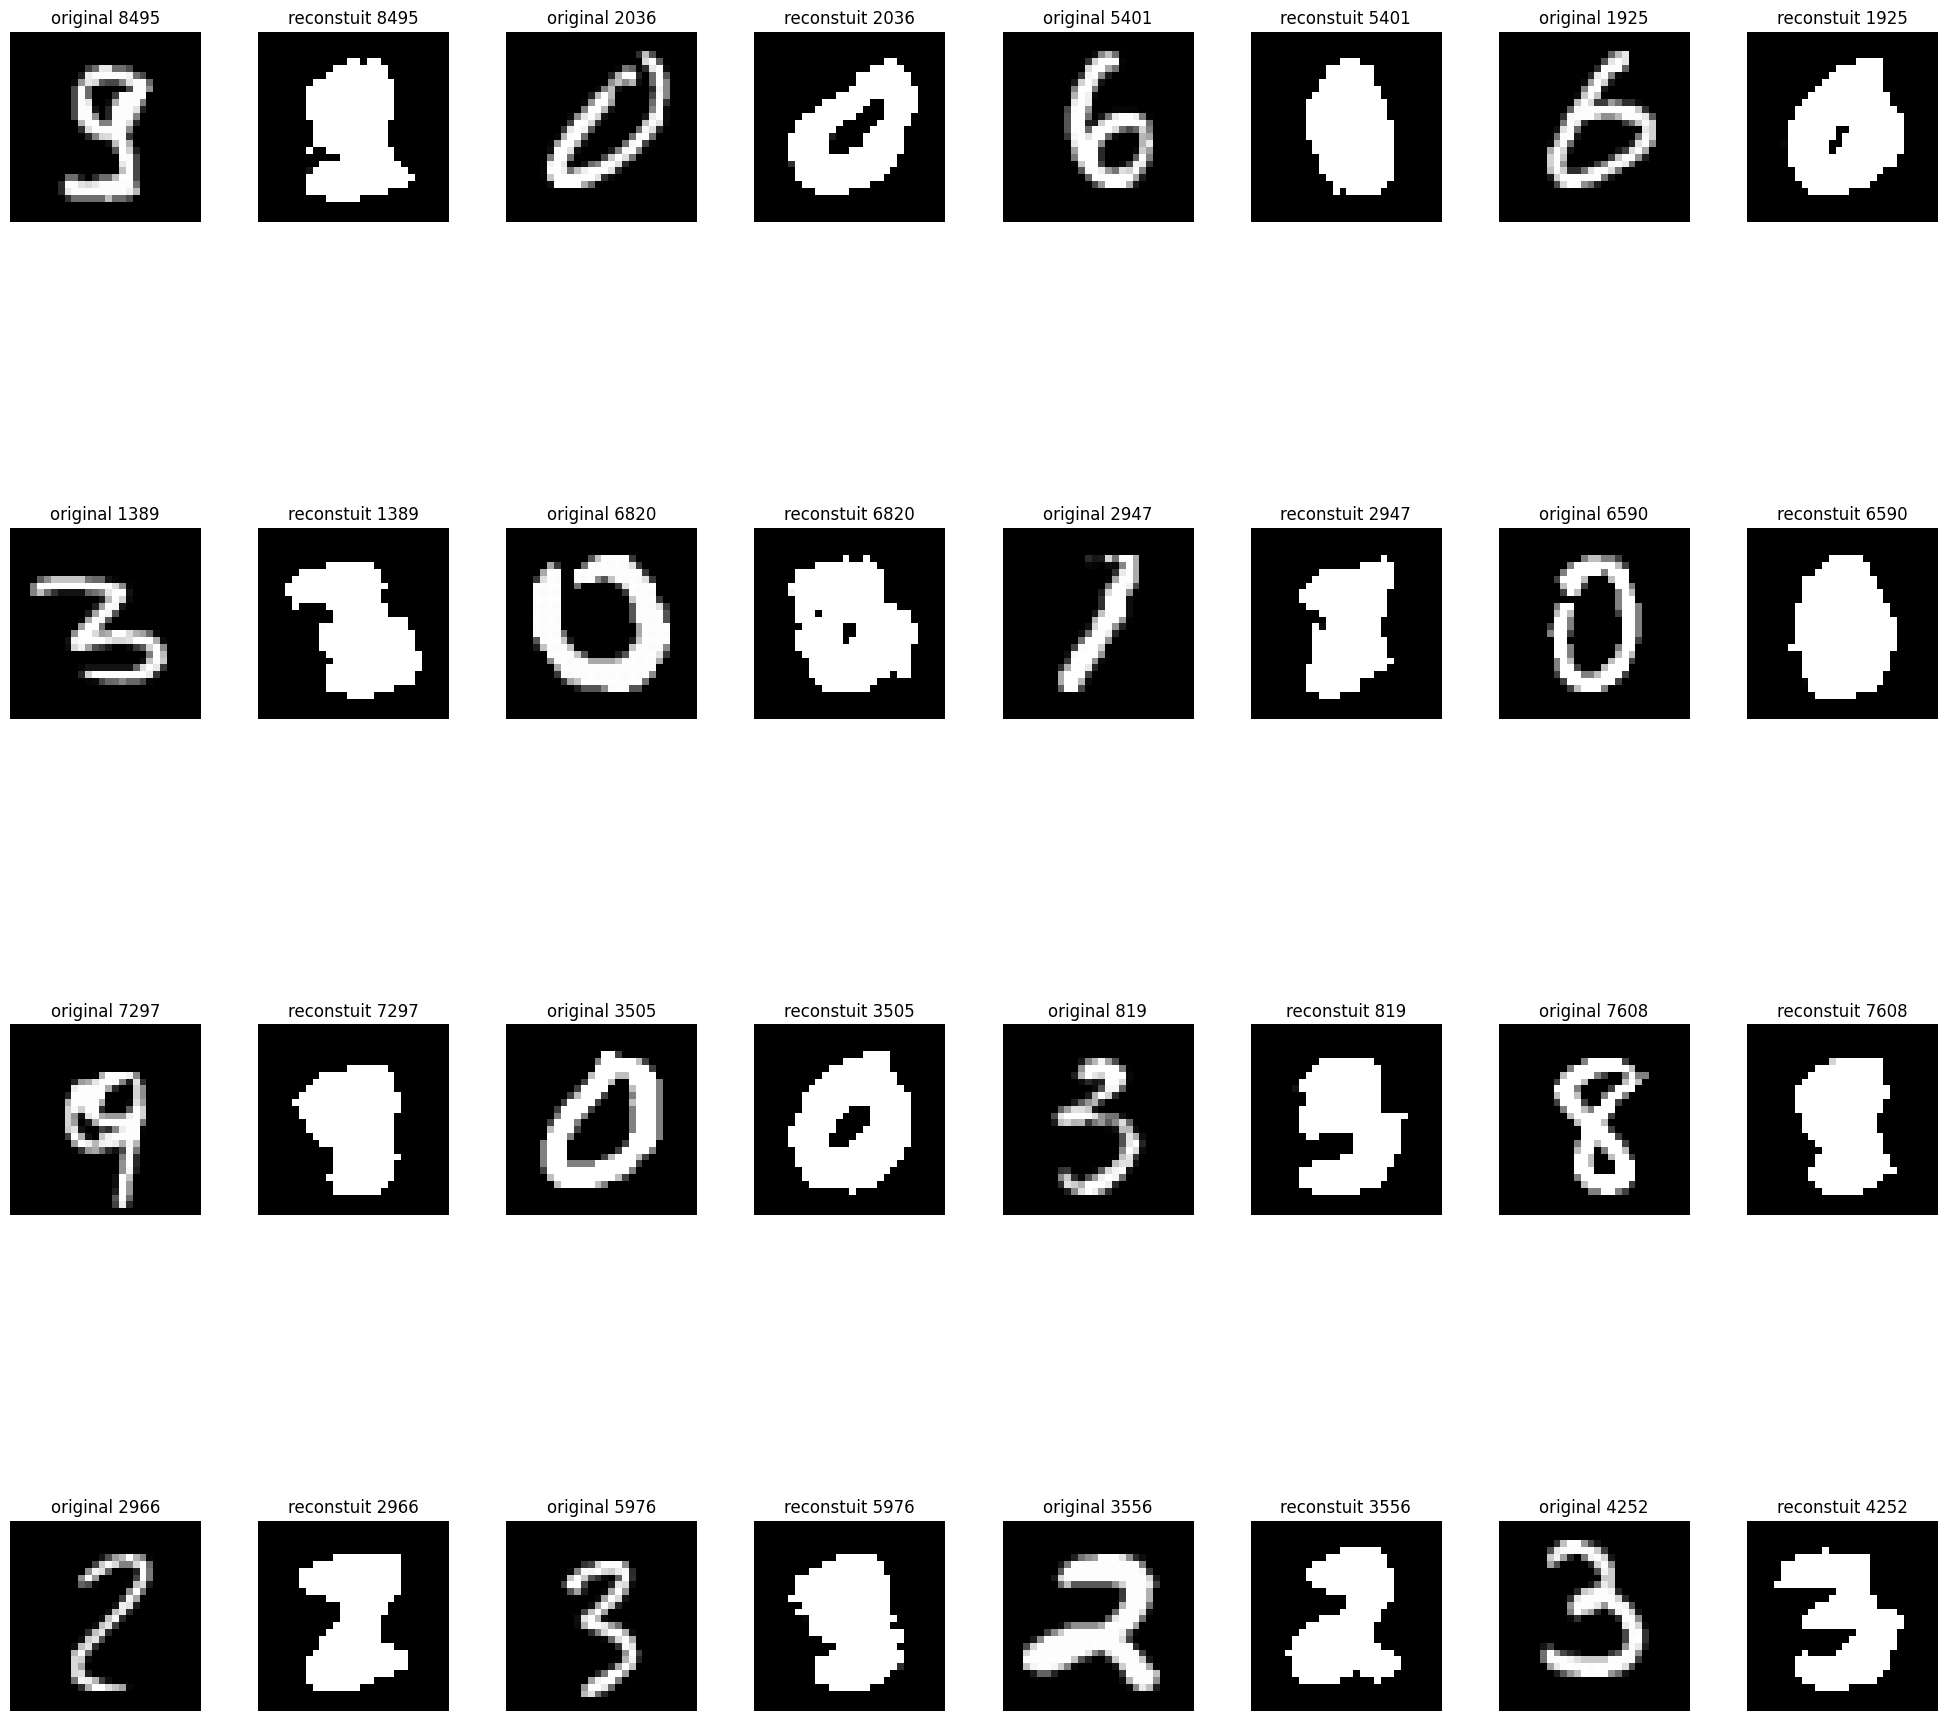

In [36]:
tools.print_auto_encoder(X_test,net_enc_256_128_16_relu,16,28)

#### melanger Relu et TanH

##### (3 couches: 1->256 2->128 3->16 ) 

In [37]:
# auto encdoder symertique

out1=256
out2=128
out3=16

BCE_loss = BCELoss()
modul_lin1_3_tan_relu  = Linear( X_train.shape[1], out1,type=1)
modul_lin2_3_tan_relu  = Linear(out1, out2,type=1)
modul_lin3_3_tan_relu  = Linear( out2, out3,type=1)
modul_lin4_3_tan_relu  = Linear( out3, out2,type=1)
modul_lin5_3_tan_relu  = Linear(out2, out1,type=1)
modul_lin6_3_tan_relu  = Linear(out1, X_train.shape[1],type=1)


modul_lin6_3_tan_relu ._parameters = modul_lin1_3_tan_relu ._parameters.T
modul_lin5_3_tan_relu ._parameters = modul_lin2_3_tan_relu ._parameters.T
modul_lin4_3_tan_relu ._parameters = modul_lin3_3_tan_relu ._parameters.T

encoder_256_128_16_tan_relu =[modul_lin1_3_tan_relu ,TanH(),modul_lin2_3_tan_relu ,TanH(),modul_lin3_3_tan_relu ,TanH()]
decoder_256_128_16_tan_relu =[modul_lin4_3_tan_relu ,ReLU(),modul_lin5_3_tan_relu ,ReLU(),modul_lin6_3_tan_relu ,Sigmoide()]

net_enc_256_128_16_tan_relu  = Sequentiel(encoder_256_128_16_tan_relu  + decoder_256_128_16_tan_relu )

opt = Optim(net_enc_256_128_16_tan_relu ,BCE_loss,1e-4)
l=opt.SGD(X_train_norm,X_train_norm,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [25:35<00:00,  7.68s/it]


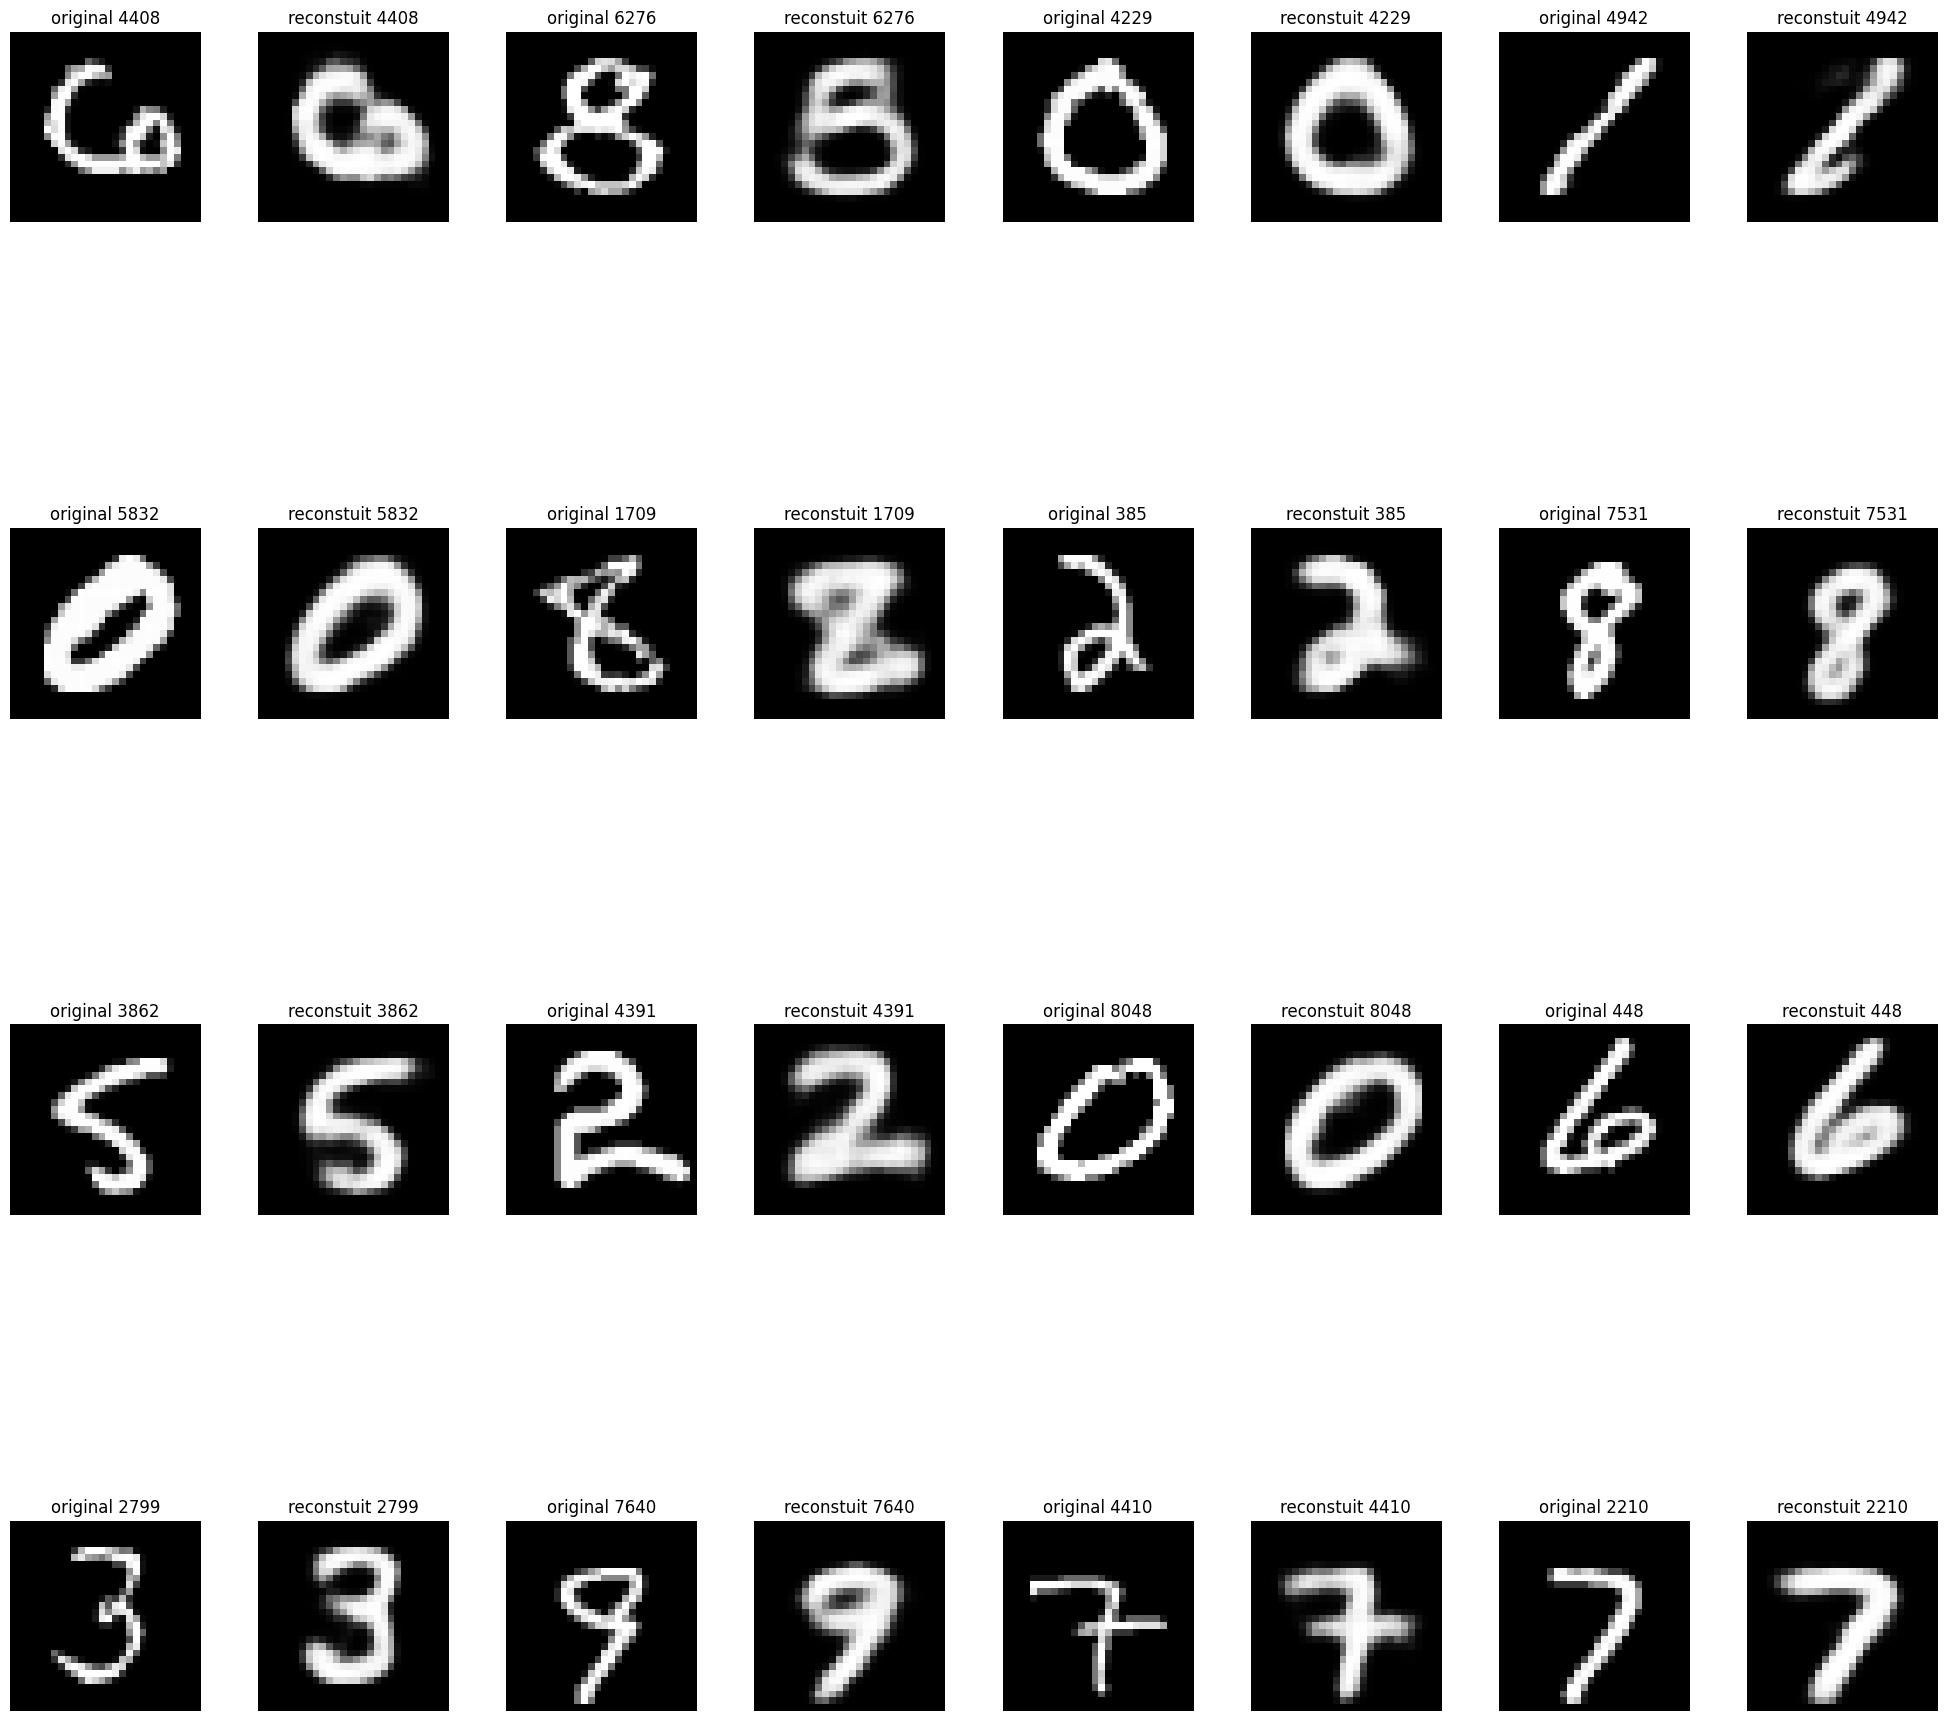

In [39]:
tools.print_auto_encoder(X_test,net_enc_256_128_16_tan_relu,16,28)

##### (3 couches: 1->512 2->256 3->2 ) 

In [43]:
# auto encdoder symertique

out1=512
out2=256
out3=2

BCE_loss = BCELoss()
modul_lin1_4_tan_relu = Linear( X_train.shape[1], out1,type=1)
modul_lin2_4_tan_relu  = Linear(out1, out2,type=1)
modul_lin3_4_tan_relu  = Linear( out2, out3,type=1)
modul_lin4_4_tan_relu  = Linear( out3, out2,type=1)
modul_lin5_4_tan_relu  = Linear(out2, out1,type=1)
modul_lin6_4_tan_relu  = Linear(out1, X_train.shape[1],type=1)


modul_lin6_4_tan_relu ._parameters = modul_lin1_4_tan_relu ._parameters.T
modul_lin5_4_tan_relu ._parameters = modul_lin2_4_tan_relu ._parameters.T
modul_lin4_4_tan_relu ._parameters = modul_lin3_4_tan_relu ._parameters.T

encoder_512_256_2_tan_relu =[modul_lin1_4_tan_relu ,TanH(),modul_lin2_4_tan_relu ,TanH(),modul_lin3_4_tan_relu ,TanH()]
decoder_512_256_2_tan_relu =[modul_lin4_4_tan_relu ,ReLU(),modul_lin5_4_tan_relu ,ReLU(),modul_lin6_4_tan_relu ,Sigmoide()]

net_enc_512_256_2_tan_relu  = Sequentiel(encoder_512_256_2_tan_relu  + decoder_512_256_2_tan_relu )

opt = Optim(net_enc_512_256_2_tan_relu,BCE_loss,1e-4)
l=opt.SGD(X_train_norm,X_train_norm,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [40:20<00:00, 12.10s/it]


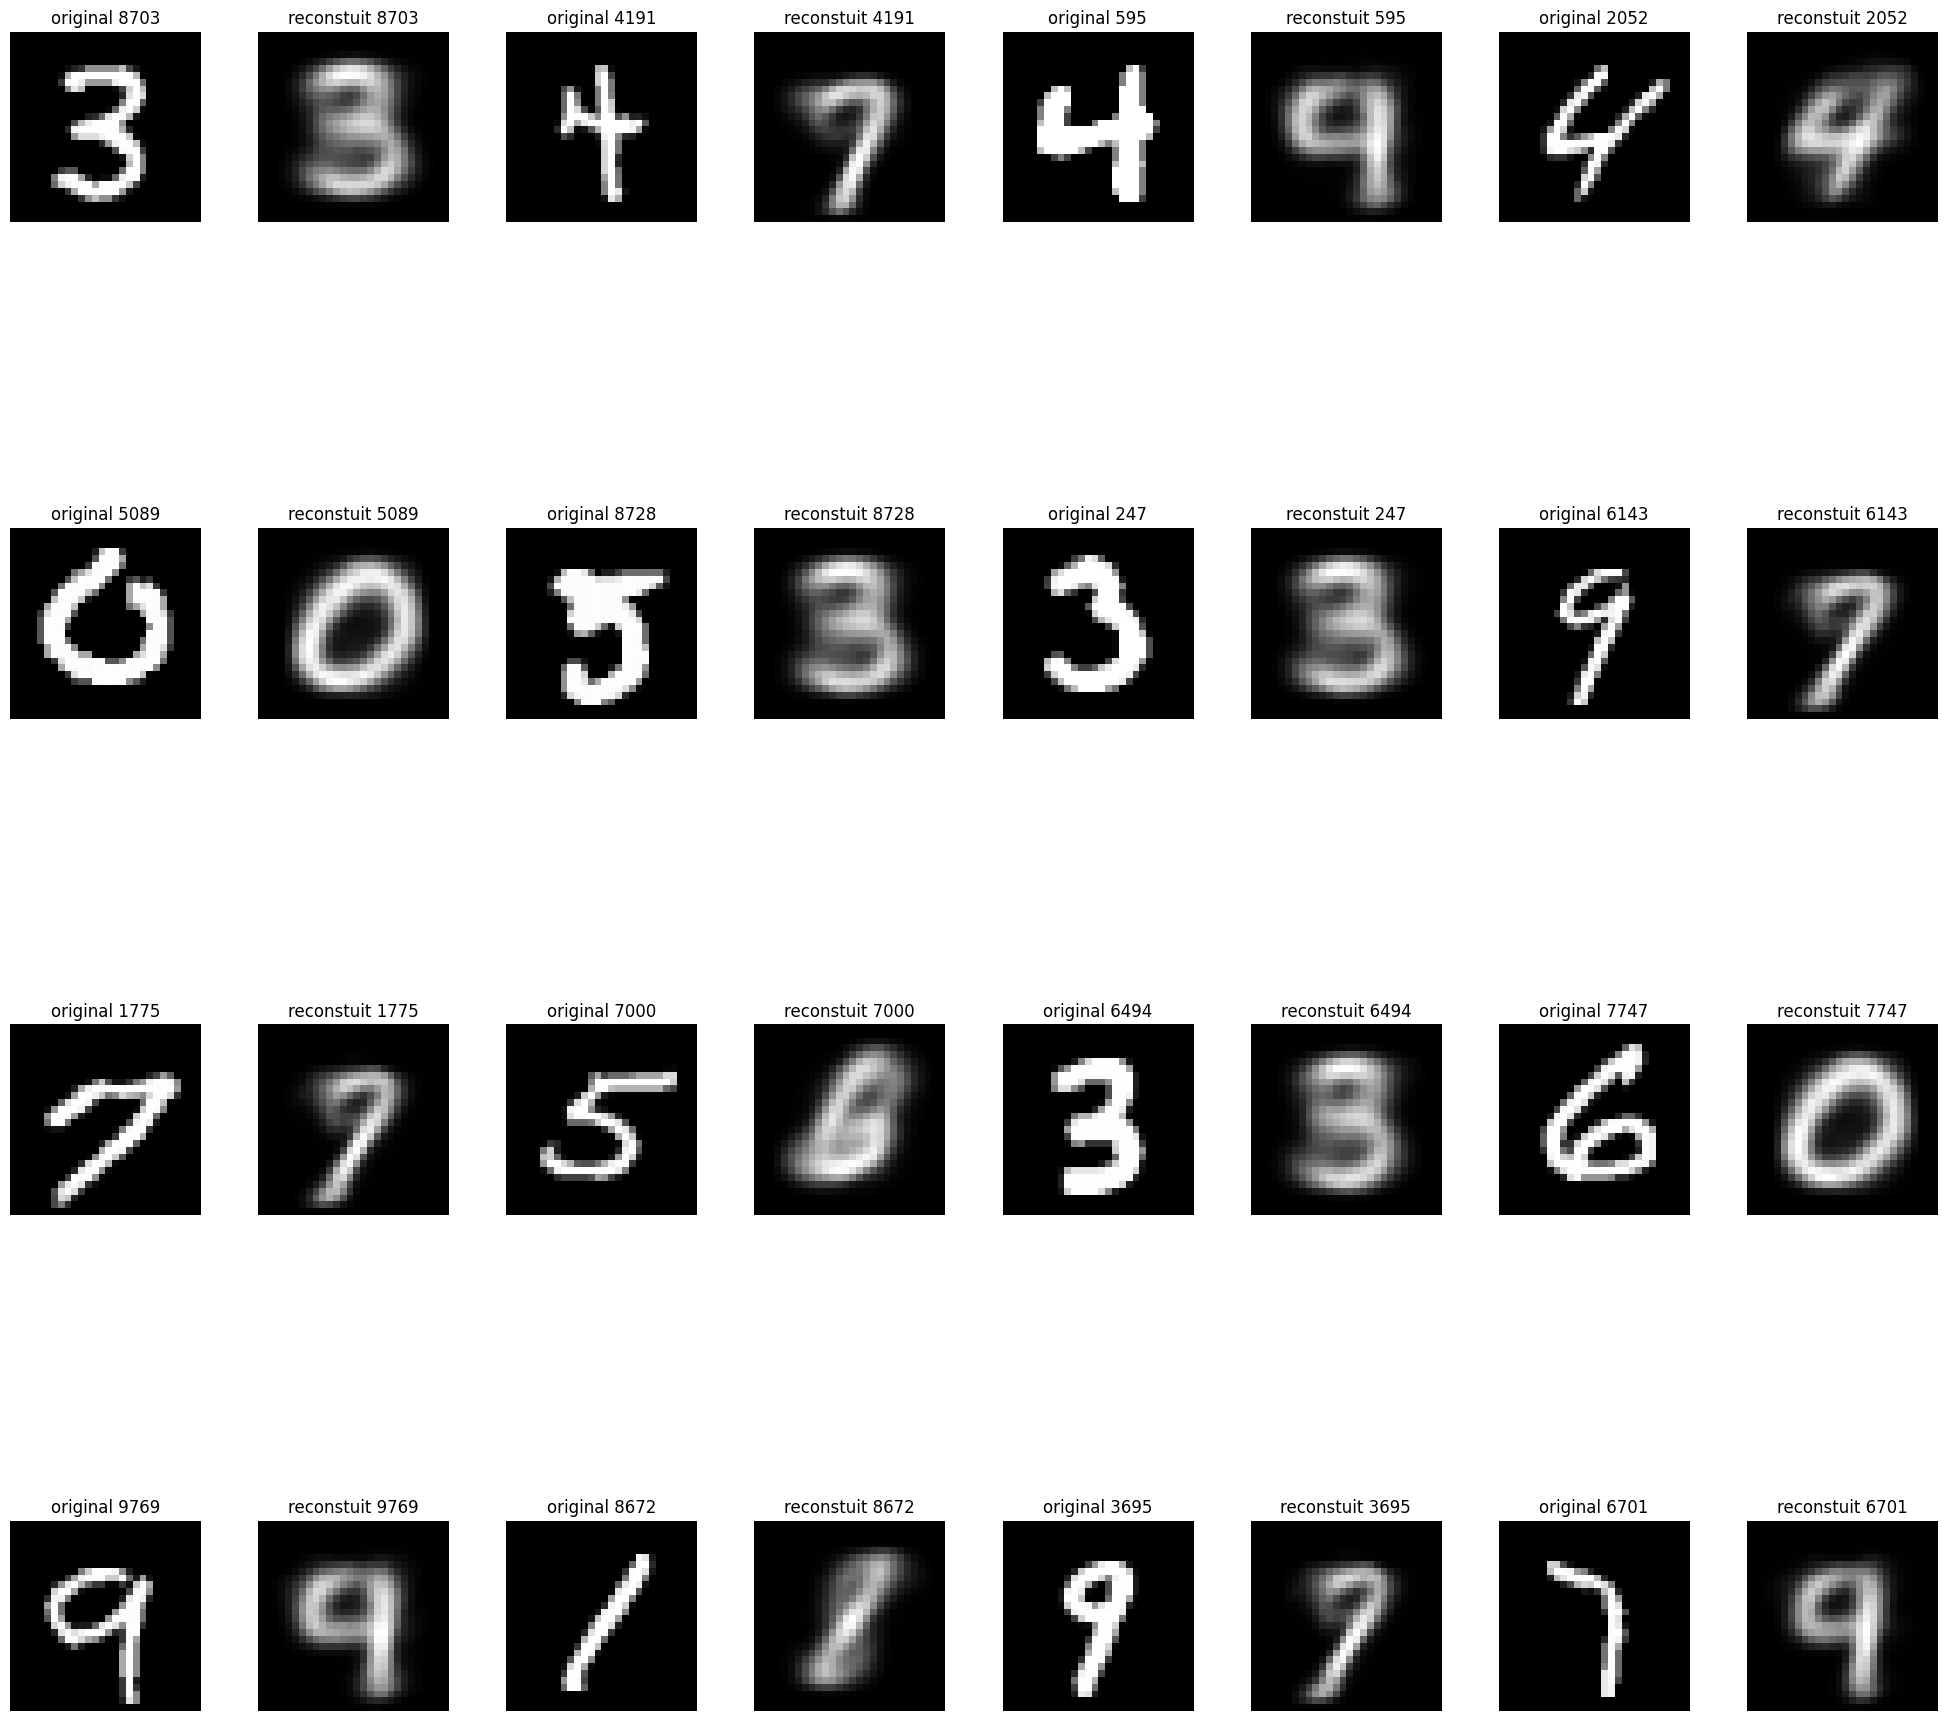

In [44]:
tools.print_auto_encoder(X_test,net_enc_512_256_2_tan_relu,16,28)

    on remarque que pour la forte compression on doit avoir en un reseau un peu long (depend de l'espace l'attente qu'on veut encoder) car dans notre example on a 28*28 pixel
    et on veut les mettre dans 2 avec une seul couche entre les 2 features qui est 512 ce n'est pas optimal car chaque couche du reseau cree des nouvelles features avec des ancienne pour rajouter de l'expressivité a notre problemme et comme dans mon example le resultat n'etait pas ouf car on manque de l'expressivité

    pour la function ReLU elle est comme un seuil un petit peu soft d'un seul coter des possitive, le resultat n'est pas bon seulement si en fait un reseau trop exprssive (long ou dense malgrer que dense a 2 couche n'est pas le plus optimal entre les 2 je pense) et la fonction TanH est plus soft c'est pour ca le resultat de relu et de noir et blanc comparer a la Tanh est plus Smoth

    et pour la 3eme j'ai choisi a commencer (la partie encoder) avec Tanh car elle est plus smoth que la ReLU, car si j'ai choisi un ReLU en premier j'aurai des valeur pos et peut etre trop de negative donc baucoup de 0 ce qui n'est pas optimal a le decoudeur

    pour palier au probleme de brutalité de la ReLU j'ai trouver une fonction qui s'appelle ELU qu'on peut utiliser a la place et qui est plus smoth malgrer que ce resultat me plais bien (ReLU + TanH) je dois la tester pour savoir si ca serais mieux si on la melange avec une TanH

    pour la visualisation je prefere le melange TanH avec ReLU car il est moins soft que la TanH seulement

# TSNE

#### données originale

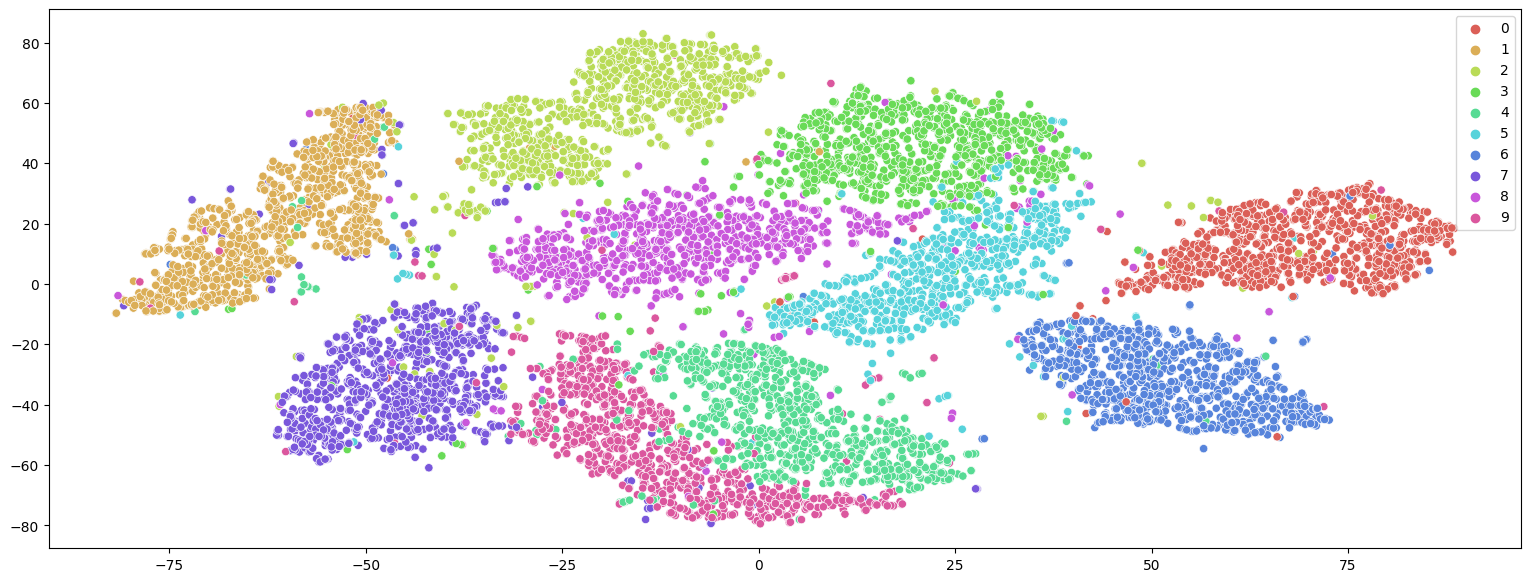

In [40]:
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(X_test)

plt.figure(figsize=(19,7))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = Y_test, palette = sns.hls_palette(10), legend = 'full')
plt.show()

#### visualisation de l'attente 16 features TanH + ReLU

(10000, 16)


<Axes: >

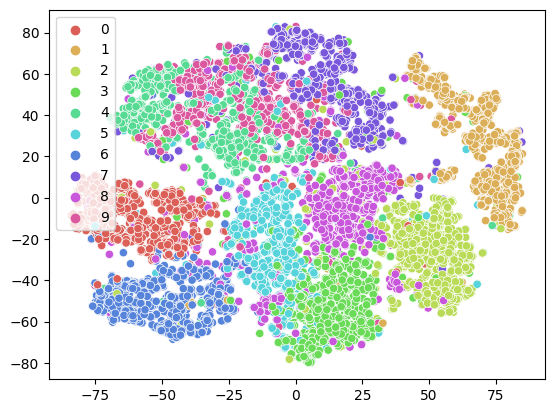

In [41]:
encoder_tsne_16 = Sequentiel(encoder_256_128_16_tan_relu)
mnist_X_16 = encoder_tsne_16.forward(X_test)

tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(mnist_X_16)
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = Y_test, palette = sns.hls_palette(10), legend = 'full')

#### visualisation de l'attente 2 features TanH + ReLU

(10000, 2)


<Axes: >

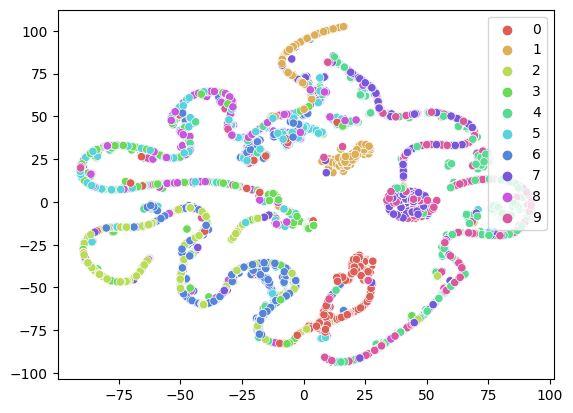

In [45]:
encoder_tsne_2 = Sequentiel(encoder_512_256_2_tan_relu)
mnist_X_2 = encoder_tsne_2.forward(X_test)

tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(mnist_X_2)
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = Y_test, palette = sns.hls_palette(10), legend = 'full')

    on peut constater que notre encoder peut stocker compresser les information de nos classe de facon a pouvoir les distinguer

# Image Bruité

## Gaussienne 0.8

In [43]:
X_train,Y_train,X_test,Y_test =tools.load_mist(50000,10000)

X_train_noise = tools.add_noise(X_train/255,p=0.8)
X_test_noise = tools.add_noise(X_test/255,p=0.8)

In [49]:
# auto encdoder symertique

out1=256
out2=128
out3=16

BCE_loss = BCELoss()
modul_lin1  = Linear( X_train.shape[1], out1,type=1)
modul_lin2  = Linear(out1, out2,type=1)
modul_lin3  = Linear( out2, out3,type=1)
modul_lin4  = Linear( out3, out2,type=1)
modul_lin5  = Linear(out2, out1,type=1)
modul_lin6  = Linear(out1, X_train.shape[1],type=1)


modul_lin6 ._parameters = modul_lin1 ._parameters.T
modul_lin5 ._parameters = modul_lin2 ._parameters.T
modul_lin4 ._parameters = modul_lin3 ._parameters.T

encoder =[modul_lin1 ,TanH(),modul_lin2 ,TanH(),modul_lin3 ,TanH()]
decoder =[modul_lin4 ,ReLU(),modul_lin5 ,ReLU(),modul_lin6 ,Sigmoide()]

net_enc  = Sequentiel(encoder  + decoder )

opt = Optim(net_enc ,BCE_loss,1e-4)
l=opt.SGD(X_train_noise,X_train/255,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [21:07<00:00,  6.34s/it]


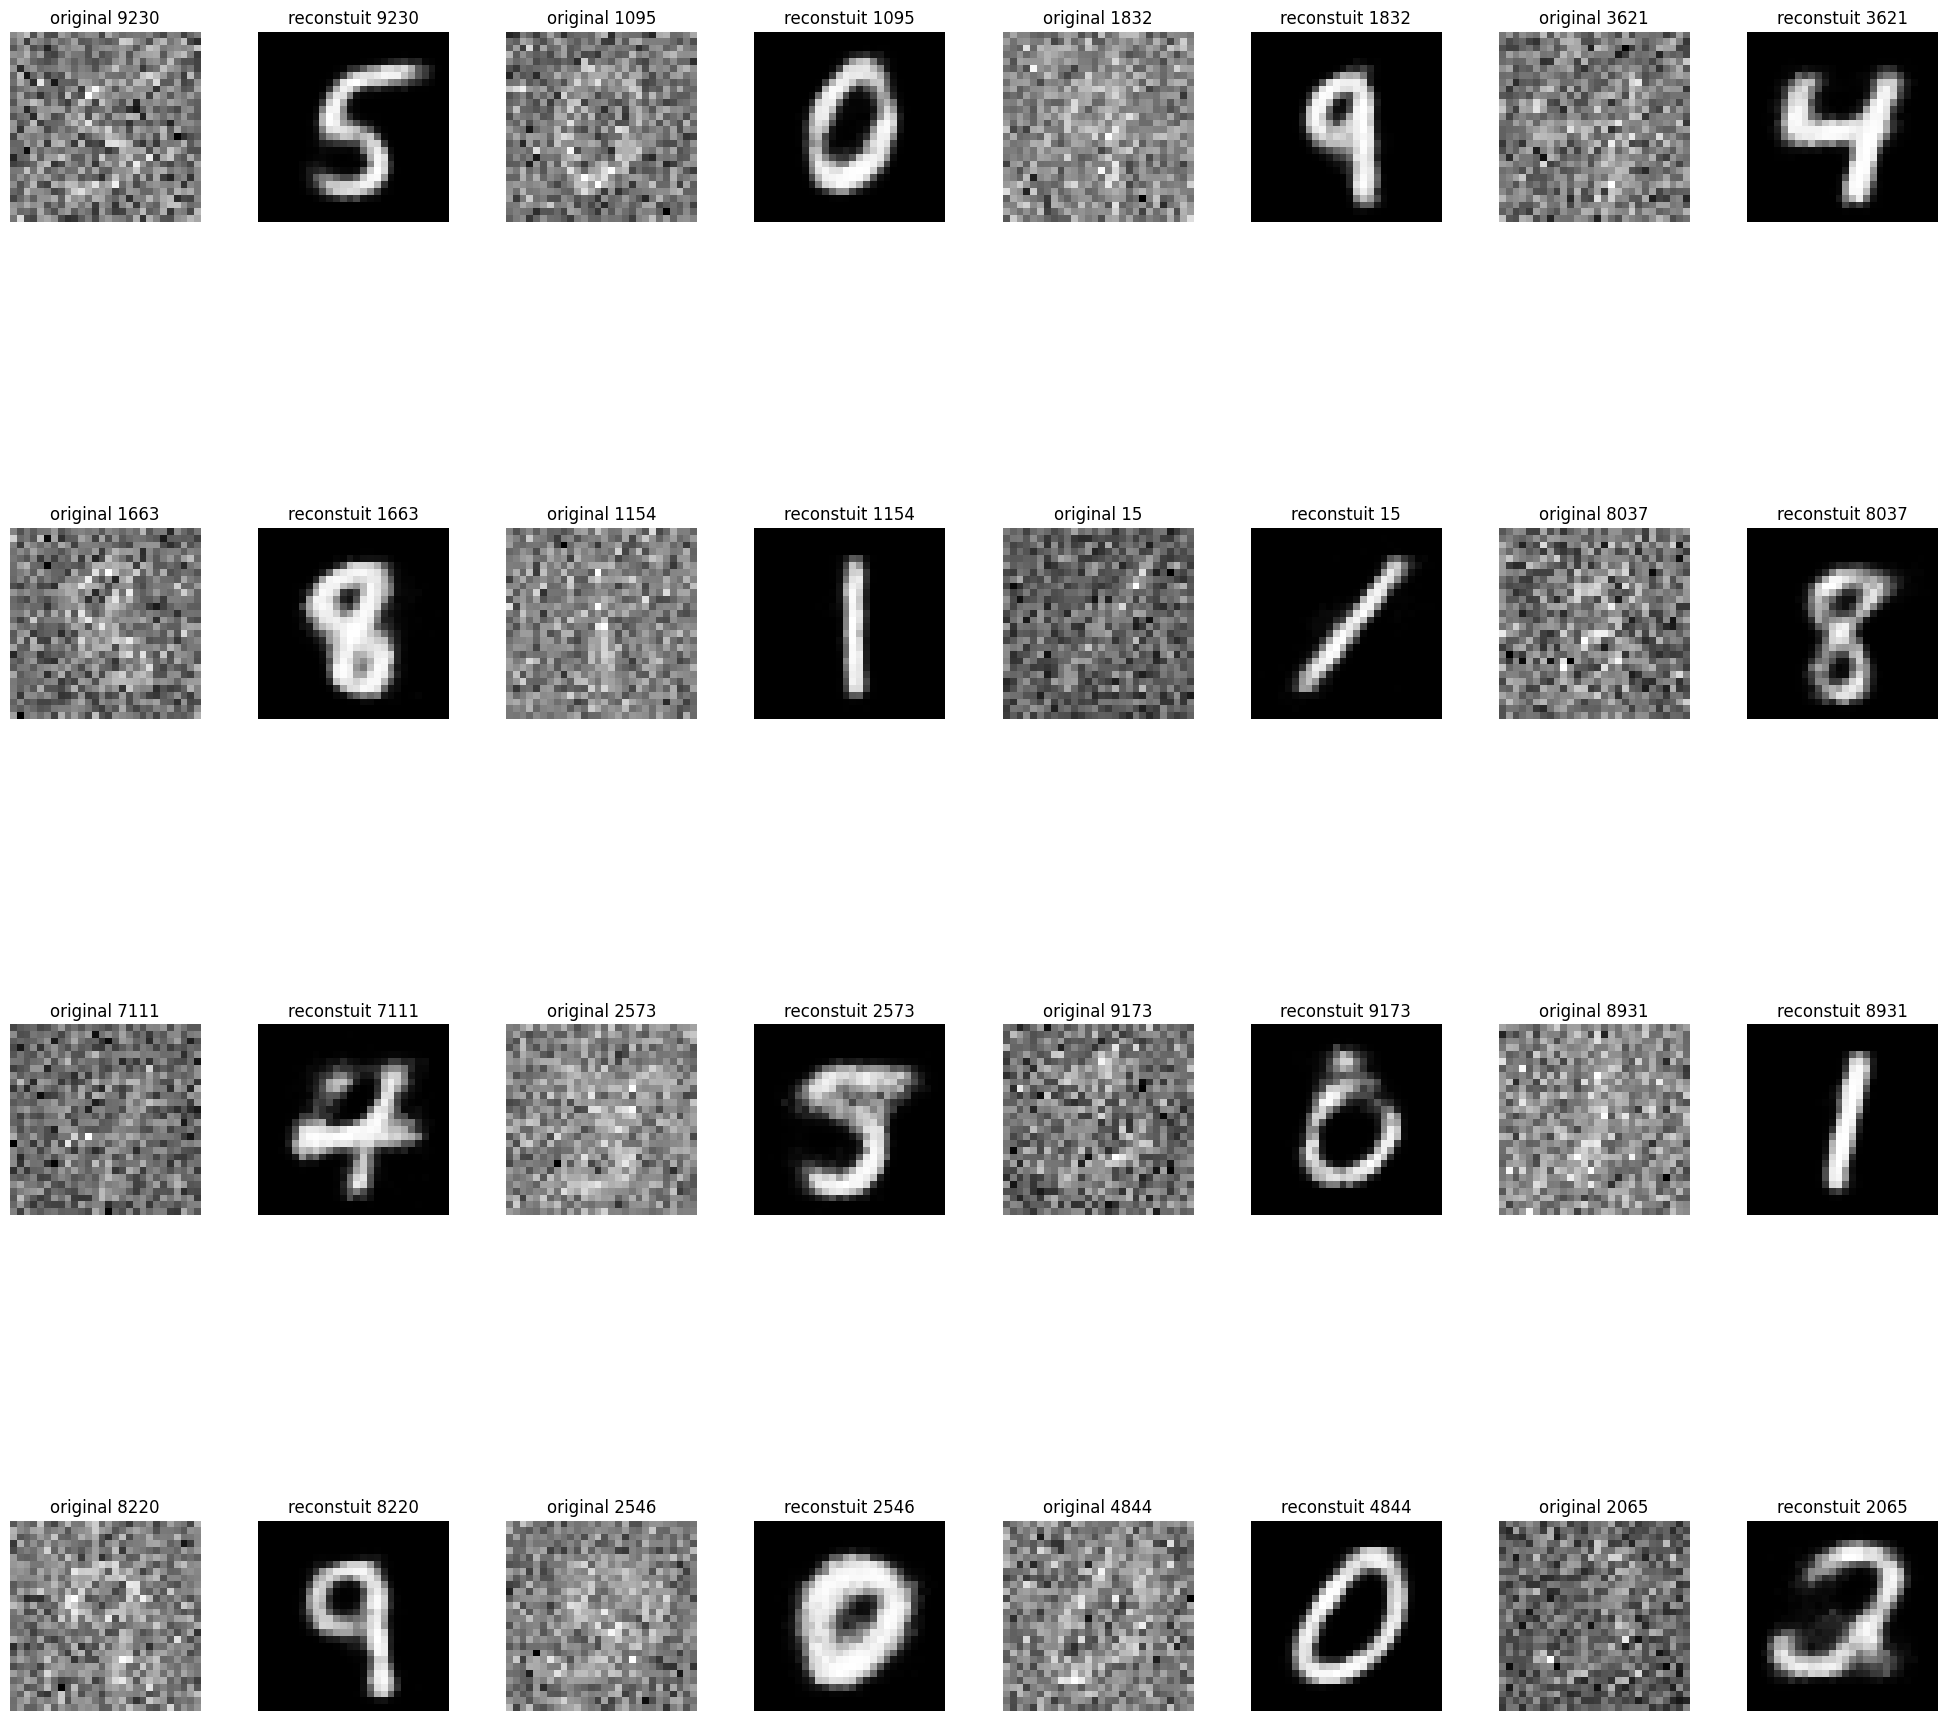

In [50]:
tools.print_auto_encoder(X_test_noise,net_enc,16,28)

## Gaussienne 1.5

In [51]:
X_train,Y_train,X_test,Y_test =tools.load_mist(50000,10000)

X_train_noise = tools.add_noise(X_train/255,p=1.5)
X_test_noise = tools.add_noise(X_test/255,p=1.5)

In [52]:
# auto encdoder symertique

out1=256
out2=128
out3=16

BCE_loss = BCELoss()
modul_lin1  = Linear( X_train.shape[1], out1,type=1)
modul_lin2  = Linear(out1, out2,type=1)
modul_lin3  = Linear( out2, out3,type=1)
modul_lin4  = Linear( out3, out2,type=1)
modul_lin5  = Linear(out2, out1,type=1)
modul_lin6  = Linear(out1, X_train.shape[1],type=1)


modul_lin6 ._parameters = modul_lin1 ._parameters.T
modul_lin5 ._parameters = modul_lin2 ._parameters.T
modul_lin4 ._parameters = modul_lin3 ._parameters.T

encoder =[modul_lin1 ,TanH(),modul_lin2 ,TanH(),modul_lin3 ,TanH()]
decoder =[modul_lin4 ,ReLU(),modul_lin5 ,ReLU(),modul_lin6 ,Sigmoide()]

net_enc  = Sequentiel(encoder  + decoder )

opt = Optim(net_enc ,BCE_loss,1e-4)
l=opt.SGD(X_train_noise,X_train/255,100,epochs=200,shuffle=True)

100%|██████████| 200/200 [20:13<00:00,  6.07s/it]


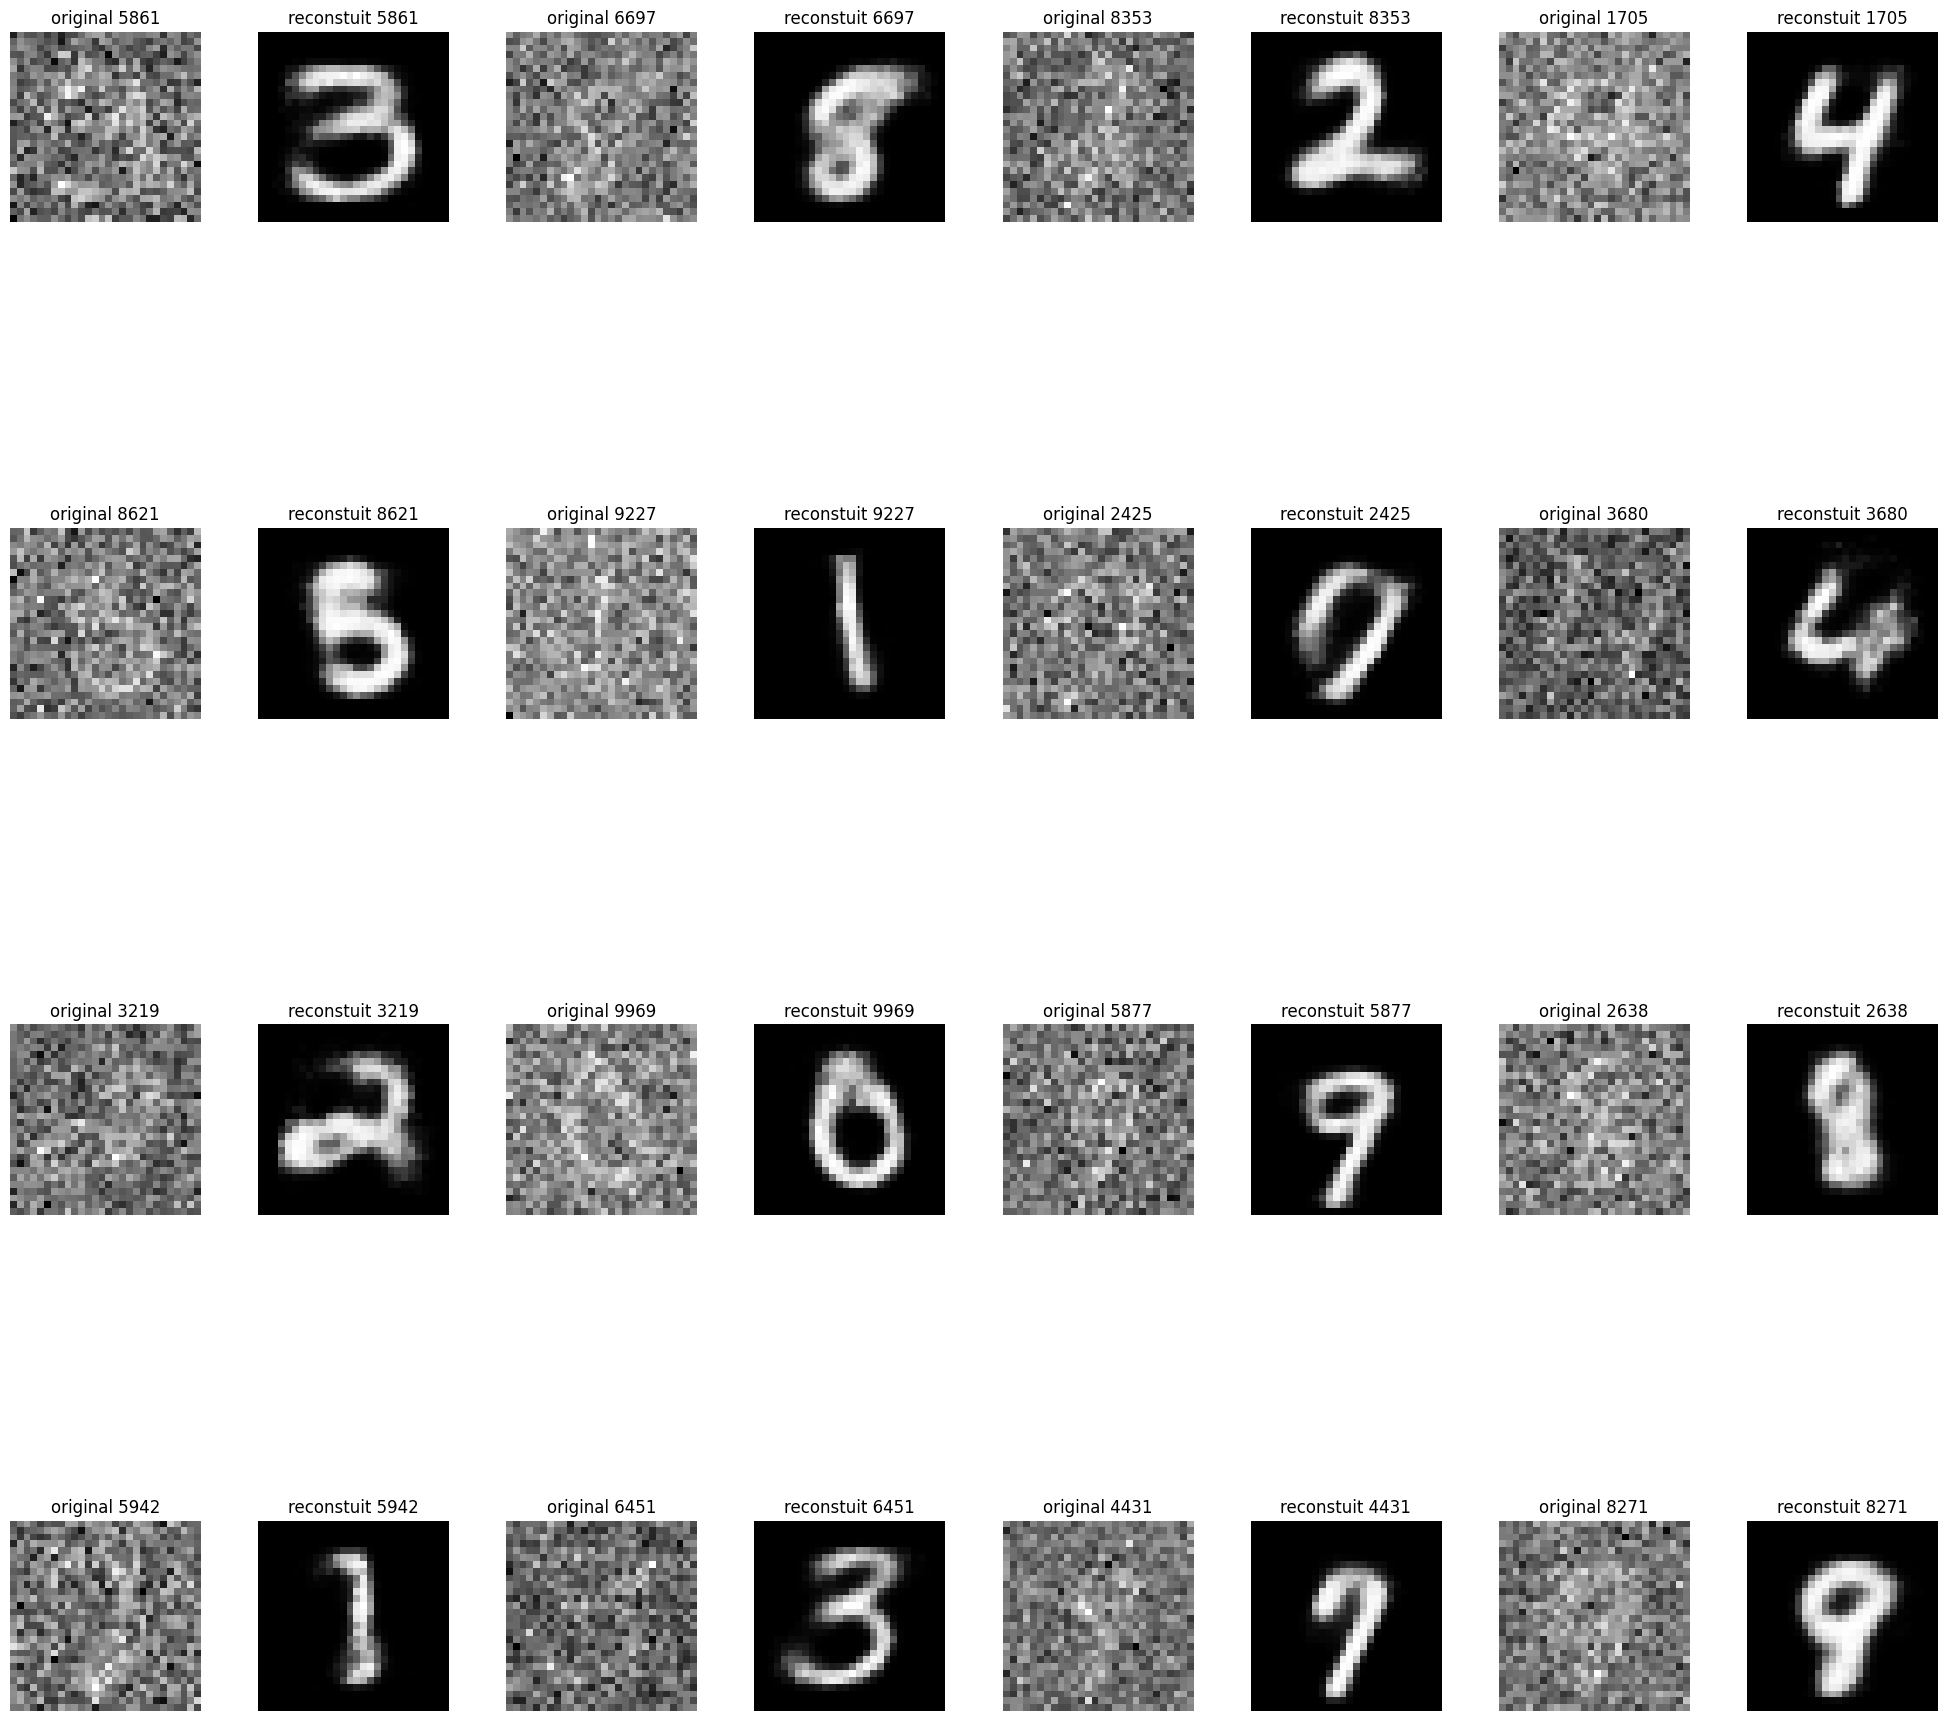

In [53]:
tools.print_auto_encoder(X_test_noise,net_enc,16,28)

    j"ai opter pour ce reseau de neurronne (encoder TanH, decoudeur ReLU) car si je fesais seulement avec la TanH le resultat seras trop trop smoth d'apres les experience d'avant

### convolution

#### conv1

In [3]:
def onehot(y):
    onehot = np.zeros((y.size,y.max()+1))
    onehot[np.arange(y.size),y]=1
    return onehot

# Load Data From USPS , directement pris depuis TME4
uspsdatatrain = "dataset/USPS_train.txt"
uspsdatatest = "dataset/USPS_test.txt"
alltrainx, alltrainy = tools.load_usps(uspsdatatrain)
alltestx, alltesty = tools.load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:5000],alltrainy[:5000]
alltestx, alltesty = alltestx[:5000],alltesty[:5000]
# taille couche
input = len(alltrainx[0])
out = len(np.unique(alltesty))
alltrainy = onehot(alltrainy)
alltesty= onehot(alltesty)
alltrainx = alltrainx.reshape(alltrainx.shape[0], alltrainx.shape[1], 1)
alltestx = alltestx.reshape(alltestx.shape[0], alltestx.shape[1], 1)

In [20]:
def pred(x):
    #retourner la meuilleur classe
    return np.argmax(x,axis=1)

score = []
iteration = 300
gradient_step = 1e-4
batch_size = 100
net = Sequentiel([Conv1D(3, 1, 32, stride=1),
                      MaxPool1D(2, 2),
                      Flatten(),
                      Linear(4064, 100,type=1),
                      ReLU(),
                      Linear(100, 10,type=1),
                      Softmax()
                      ],label=pred)

optim1 = Optim(net, CELoss(), eps=1e-3)        

l_loss= optim1.SGD(alltrainx, alltrainy,batch_size,iteration,shuffle=True)


100%|██████████| 300/300 [11:33<00:00,  2.31s/it]


Text(0.5, 1.0, 'variation de la fonction de cout')

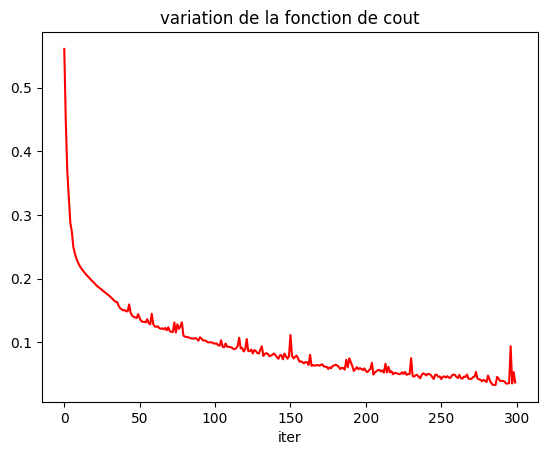

In [21]:
plt.plot(np.arange(iteration),l_loss,color='red',label="la function de cout")
plt.xlabel("iter")
plt.title("variation de la fonction de cout")

In [22]:
alltrainx, alltrainy = tools.load_usps(uspsdatatrain)
alltestx, alltesty = tools.load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:5000],alltrainy[:5000]
alltestx, alltesty = alltestx[:5000],alltesty[:5000]
alltrainx = alltrainx.reshape(alltrainx.shape[0], alltrainx.shape[1], 1)
alltestx = alltestx.reshape(alltestx.shape[0], alltestx.shape[1], 1)

predict = optim1._net.predict(alltrainx)
print((np.where(predict == alltrainy, 1, 0)).mean() )

0.9824


#### conv2

In [2]:
#taille couche
def onehot(y):
    onehot = np.zeros((y.size,y.max()+1))
    onehot[np.arange(y.size),y]=1
    return onehot

def pred(x):
    #retourner la meuilleur classe
    return np.argmax(x,axis=1)

uspsdatatrain = "dataset/USPS_train.txt"
uspsdatatest = "dataset/USPS_test.txt"
alltrainx, alltrainy = tools.load_usps(uspsdatatrain)
alltestx, alltesty = tools.load_usps(uspsdatatest)
alltrainx, alltrainy = tools.load_usps(uspsdatatrain)
alltestx, alltesty = tools.load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:1000],alltrainy[:1000]
alltestx, alltesty = alltestx[:1000],alltesty[:1000]

alltrainy = onehot(alltrainy)
alltesty= onehot(alltesty)

alltrainx=alltrainx.reshape(alltrainx.shape[0],16,16,1)
alltestx=alltestx.reshape(alltestx.shape[0],16,16,1)

iteration = 200
gradient_step = 1e-2
batch_size = 70


net = Sequentiel([Conv2D(3, 1, 32, stride=1),
                      MaxPool2D(2, 2),
                      Flatten(),
                      Linear(1568,100,type=1),
                      ReLU(),
                      Linear(100, 10,type=1),
                      Softmax()
                      ],label=pred)

optim = Optim(net, CELoss(), 1e-3)        

l_loss= optim.SGD(alltrainx, alltrainy,batch_size,iteration,200)

100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


Text(0.5, 1.0, 'variation de la fonction de cout')

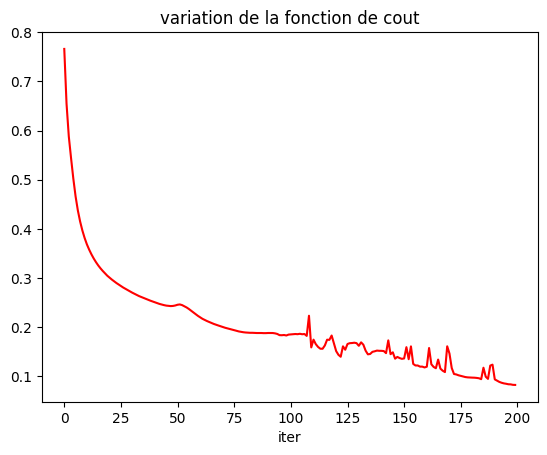

In [3]:
plt.plot(np.arange(iteration),l_loss,color='red',label="la function de cout")
plt.xlabel("iter")
plt.title("variation de la fonction de cout")

In [4]:
alltrainx, alltrainy = tools.load_usps(uspsdatatrain)
alltestx, alltesty = tools.load_usps(uspsdatatest)
alltrainx, alltrainy = alltrainx[:1000],alltrainy[:1000]
alltestx, alltesty = alltestx[:1000],alltesty[:1000]

alltrainx=alltrainx.reshape(alltrainx.shape[0],16,16,1)
alltestx=alltestx.reshape(alltestx.shape[0],16,16,1)

In [5]:
predict = optim._net.predict(alltrainx)
print((np.where(predict == alltrainy, 1, 0)).mean() )

0.965
